In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from transformers import BertModel, BertTokenizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
import joblib

In [3]:
df1=pd.read_csv(r'/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2=pd.read_csv(r'/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3=pd.read_csv(r'/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv')
df4=pd.read_csv(r'/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')

In [4]:
df1[' Label'].value_counts()

 Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

In [5]:
df2[' Label'].value_counts()

 Label
PortScan    158930
BENIGN      127537
Name: count, dtype: int64

In [6]:
df3[' Label'].value_counts()

 Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [7]:
df4[' Label'].value_counts()

 Label
BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: count, dtype: int64

In [8]:
df3[' Label']=df3[' Label'].apply(lambda i:i if i=='BENIGN' else 'DoS')
df4[' Label']=df4[' Label'].apply(lambda i:i if i=='BENIGN' else 'Web Attack')

In [9]:
df=pd.concat([df1,df2,df3,df4],axis=0)

In [10]:
df

Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
1                   55054             109                   1   
2                   55055              52                   1   
3                   46236              34                   1   
4                   54863               3                   2   
...                   ...             ...                 ...   
170361              55641              49                   1   
170362              45337             217                   2   
170363                 22         1387547                  41   
170364                 22             207                   1   
170365              60146              50                   1   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
1                             1                            6   
2                             1                            6   
3                             1                            6   
4                             0                           12   
...                         ...                          ...   
170361                        3                            6   
170362                        1                           31   
170363                       46                         2728   
170364                        1                            0   
170365                        2                            0   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                  0                       6   
1                                  6                       6   
2                                  6                       6   
3                                  6                       6   
4                                  0                       6   
...                              ...                     ...   
170361                            18                       6   
170362                             6                      31   
170363                          6634                     456   
170364                             0                       0   
170365                             0                       0   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
0                            6                 6.000000   
1                            6                 6.000000   
2                            6                 6.000000   
3                            6                 6.000000   
4                            6                 6.000000   
...                        ...                      ...   
170361                       6                 6.000000   
170362                       0                15.500000   
170363                       0                66.536585   
170364                       0                 0.000000   
170365                       0                 0.000000   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                     0.000000  ...                     20          0.0   
1                     0.000000  ...                     20          0.0   
2                     0.000000  ...                     20          0.0   
3                     0.000000  ...                     20          0.0   
4                     0.000000  ...                     20          0.0   
...                        ...  ...                    ...          ...   
170361                0.000000  ...                     20          0.0   
170362               21.920310  ...                     32          0.0   
170363              110.129945  ...                     32          0.0   
170364                0.000000  ...                     32          0.0   
170365                0.000000  ...                     32          0.0   

         Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
0        

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1375281 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1375281 non-null  int64  
 1    Flow Duration                1375281 non-null  int64  
 2    Total Fwd Packets            1375281 non-null  int64  
 3    Total Backward Packets       1375281 non-null  int64  
 4   Total Length of Fwd Packets   1375281 non-null  int64  
 5    Total Length of Bwd Packets  1375281 non-null  int64  
 6    Fwd Packet Length Max        1375281 non-null  int64  
 7    Fwd Packet Length Min        1375281 non-null  int64  
 8    Fwd Packet Length Mean       1375281 non-null  float64
 9    Fwd Packet Length Std        1375281 non-null  float64
 10  Bwd Packet Length Max         1375281 non-null  int64  
 11   Bwd Packet Length Min        1375281 non-null  int64  
 12   Bwd Packet Length Mean       1375

In [12]:
null_cols=df.isnull().sum()
null_cols[null_cols>0]

Flow Bytes/s    1047
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
null_cols=df.isnull().sum()
null_cols[null_cols>0]

Series([], dtype: int64)

In [15]:
df.describe()

Destination Port   Flow Duration   Total Fwd Packets  \
count       1.374234e+06    1.374234e+06        1.374234e+06   
mean        6.978682e+03    1.944915e+07        8.215337e+00   
std         1.676204e+04    3.738210e+07        6.617603e+02   
min         0.000000e+00   -1.300000e+01        1.000000e+00   
25%         5.300000e+01    1.420000e+02        1.000000e+00   
50%         8.000000e+01    4.766000e+04        2.000000e+00   
75%         4.430000e+02    6.249969e+06        5.000000e+00   
max         6.553200e+04    1.200000e+08        2.039430e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             1.374234e+06                 1.374234e+06   
mean              8.867809e+00                 5.518338e+02   
std               8.748837e+02                 5.387528e+03   
min               0.000000e+00                 0.000000e+00   
25%               1.000000e+00                 6.000000e+00   
50%               2.000000e+00                 5.600000e+01   
75%               5.000000e+00                 3.190000e+02   
max               2.723530e+05                 1.224076e+06   

        Total Length of Bwd Packets   Fwd Packet Length Max  \
count                  1.374234e+06            1.374234e+06   
mean                   1.405698e+04            2.439029e+02   
std                    2.004384e+06            9.076688e+02   
min                    0.000000e+00            0.000000e+00   
25%                    6.000000e+00            6.000000e+00   
50%                    1.180000e+02            3.400000e+01   
75%                    3.710000e+03            2.040000e+02   
max                    6.270000e+08            2.482000e+04   

        Fwd Packet Length Min   Fwd Packet Length Mean  \
count            1.374234e+06             1.374234e+06   
mean             1.712418e+01             6.861130e+01   
std              7.766769e+01             2.425153e+02   
min              0.000000e+00             0.000000e+00   
25%              0.000000e+00             6.000000e+00   
50%              0.000000e+00             3.200000e+01   
75%              3.100000e+01             5.000000e+01   
max              2.065000e+03             4.640758e+03   

        Fwd Packet Length Std  ...   act_data_pkt_fwd   min_seg_size_forward  \
count            1.374234e+06  ...       1.374234e+06           1.374234e+06   
mean             8.806965e+01  ...       5.468215e+00           2.622656e+01   
std              3.732099e+02  ...       6.339715e+02           6.852220e+00   
min              0.000000e+00  ...       0.000000e+00          -1.000000e+00   
25%              0.000000e+00  ...       0.000000e+00           2.000000e+01   
50%              0.000000e+00  ...       1.000000e+00           2.400000e+01   
75%              7.445065e+01  ...       2.000000e+00           3.200000e+01   
max              6.692645e+03  ...       1.971240e+05           6.000000e+01   

        Active Mean    Active Std    Active Max    Active Min     Idle Mean  \
count  1.374234e+06  1.374234e+06  1.374234e+06  1.374234e+06  1.374234e+06   
mean   9.318118e+04  3.670350e+04  1.528524e+05  7.175092e+04  1.363277e+07   
std    6.684722e+05  3.899185e+05  9.869884e+05  6.034920e+05  3.046346e+07   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.000000e+00  0.000000e+00  4.000000e+00  4.000000e+00  5.573010e+06   
max    1.100000e+08  7.420000e+07  1.100000e+08  1.100000e+08  1.200000e+08   

           Idle Std      Idle Max      Idle Min  
count  1.374234e+06  1.374234e+06  1.374234e+06  
mean   8.614558e+05  1.428047e+07  1.298869e+07  
std    6.251948e+06  3.138610e+07  3.020725e+07  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.00

In [16]:
duplicates=df.duplicated()
duplicates[duplicates==True]

2109      True
2257      True
2749      True
2862      True
2877      True
          ... 
170314    True
170343    True
170350    True
170360    True
170364    True
Length: 177637, dtype: bool

In [17]:
df.drop_duplicates()

Destination Port   Flow Duration   Total Fwd Packets  \
0                   54865               3                   2   
1                   55054             109                   1   
2                   55055              52                   1   
3                   46236              34                   1   
4                   54863               3                   2   
...                   ...             ...                 ...   
170359                 22         1286687                  41   
170361              55641              49                   1   
170362              45337             217                   2   
170363                 22         1387547                  41   
170365              60146              50                   1   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             0                           12   
1                             1                            6   
2                             1                            6   
3                             1                            6   
4                             0                           12   
...                         ...                          ...   
170359                       42                         2664   
170361                        3                            6   
170362                        1                           31   
170363                       46                         2728   
170365                        2                            0   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                  0                       6   
1                                  6                       6   
2                                  6                       6   
3                                  6                       6   
4                                  0                       6   
...                              ...                     ...   
170359                          6954                     456   
170361                            18                       6   
170362                             6                      31   
170363                          6634                     456   
170365                             0                       0   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
0                            6                 6.000000   
1                            6                 6.000000   
2                            6                 6.000000   
3                            6                 6.000000   
4                            6                 6.000000   
...                        ...                      ...   
170359                       0                64.975610   
170361                       6                 6.000000   
170362                       0                15.500000   
170363                       0                66.536585   
170365                       0                 0.000000   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                     0.000000  ...                     20          0.0   
1                     0.000000  ...                     20          0.0   
2                     0.000000  ...                     20          0.0   
3                     0.000000  ...                     20          0.0   
4                     0.000000  ...                     20          0.0   
...                        ...  ...                    ...          ...   
170359              109.864573  ...                     32          0.0   
170361                0.000000  ...                     20          0.0   
170362               21.920310  ...                     32          0.0   
170363              110.129945  ...                     32          0.0   
170365                0.000000  ...                     32          0.0   

         Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
0        

In [18]:
df[' Label'].value_counts()

 Label
BENIGN        833374
DoS           251723
PortScan      158930
DDoS          128027
Web Attack      2180
Name: count, dtype: int64

In [19]:
le = LabelEncoder()
df[' Label'] = le.fit_transform(df[' Label'])

In [20]:
joblib.dump(le,'label_encoder.pkl')

['label_encoder.pkl']

In [21]:
classes=le.inverse_transform([0,1,2,3,4])
classes

array(['BENIGN', 'DDoS', 'DoS', 'PortScan', 'Web Attack'], dtype=object)

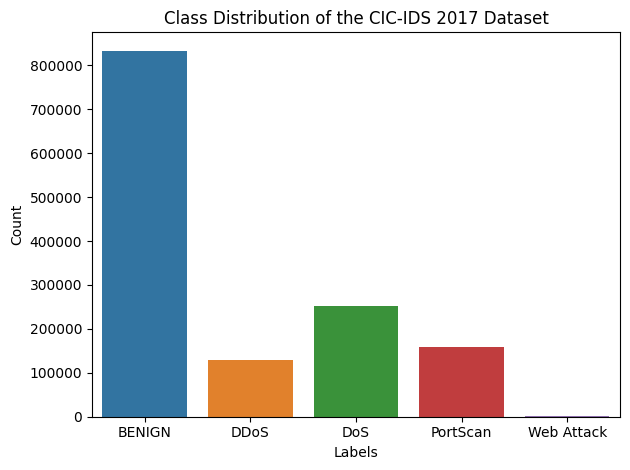

In [22]:
plt.title('Class Distribution of the CIC-IDS 2017 Dataset')
ax=sns.countplot(x=' Label',data=df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.tight_layout()
ax.set_xticklabels(classes)
plt.savefig('count_plot.jpg',dpi=300,bbox_inches='tight')
plt.show()

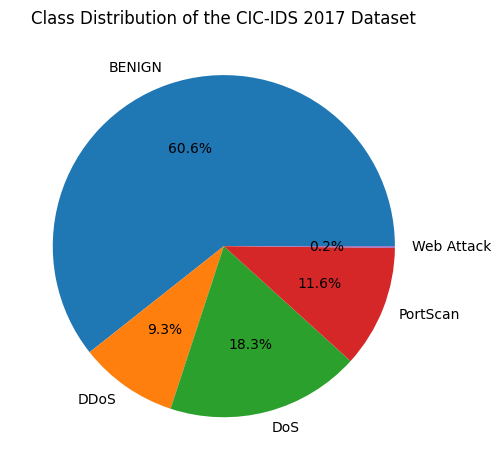

In [23]:
unique,counts=np.unique(df[' Label'],return_counts=True)
labels=le.inverse_transform(unique)

plt.title('Class Distribution of the CIC-IDS 2017 Dataset')
plt.pie(counts,labels=labels,autopct='%.1f%%')
plt.tight_layout()
plt.savefig('pie_chart.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [24]:
df_normal=df[df[' Label']==0]
df_attacks=df[df[' Label']!=0]

In [25]:
df_normal=df_normal.sample(260000,random_state=42)
df_normal.shape

(260000, 79)

In [26]:
df=pd.concat([df_normal,df_attacks],axis=0)
df

Destination Port   Flow Duration   Total Fwd Packets  \
75662                  53             235                   2   
446208                 80         5379902                   4   
481839                 80        19129215                   6   
215873                443         5996274                  11   
32712                  21              49                   1   
...                   ...             ...                 ...   
92885                  80         5005388                   5   
92984                  80         5016759                   5   
93233                  80         5009163                   4   
93242                  80              73                   1   
93286                  80             109                   1   

         Total Backward Packets  Total Length of Fwd Packets  \
75662                         2                           70   
446208                        2                           12   
481839                        4                          318   
215873                       11                         1228   
32712                         2                            0   
...                         ...                          ...   
92885                         3                          599   
92984                         5                          599   
93233                         4                          599   
93242                         1                            0   
93286                         1                            0   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
75662                            178                      35   
446208                             0                       6   
481839                           451                     318   
215873                          8879                     497   
32712                              0                       0   
...                              ...                     ...   
92885                           2021                     599   
92984                           4149                     599   
93233                           2021                     599   
93242                              0                       0   
93286                              0                       0   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
75662                       35                35.000000   
446208                       0                 3.000000   
481839                       0                53.000000   
215873                       0               111.636364   
32712                        0                 0.000000   
...                        ...                      ...   
92885                        0               119.800000   
92984                        0               119.800000   
93233                        0               149.750000   
93242                        0                 0.000000   
93286                        0                 0.000000   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
75662                 0.000000  ...                     32          0.0   
446208                3.464102  ...                     20          0.0   
481839              129.822956  ...                     32     129762.0   
215873              173.544388  ...                     20          0.0   
32712                 0.000000  ...                     32          0.0   
...                        ...  ...                    ...          ...   
92885               267.880944  ...                     32          0.0   
92984               267.880944  ...                     32          0.0   
93233               299.500000  ...                     32          0.0   
93242                 0.000000  ...                     32          0.0   
93286                 0.000000  ...                     32          0.0   

         Active Std   Active Max   Active Min   Idle Mean   Idle Std  \
75662   

In [27]:
x = df.drop(" Label",axis=1)
y = df[[' Label']]

In [28]:
X_train , X_test , Y_train , Y_test  = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [29]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((640688, 78), (640688, 1), (160172, 78), (160172, 1))

In [30]:
validation_data=pd.concat([X_test,Y_test],axis=1)
validation_data.to_csv('validation_data.csv')

In [31]:
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

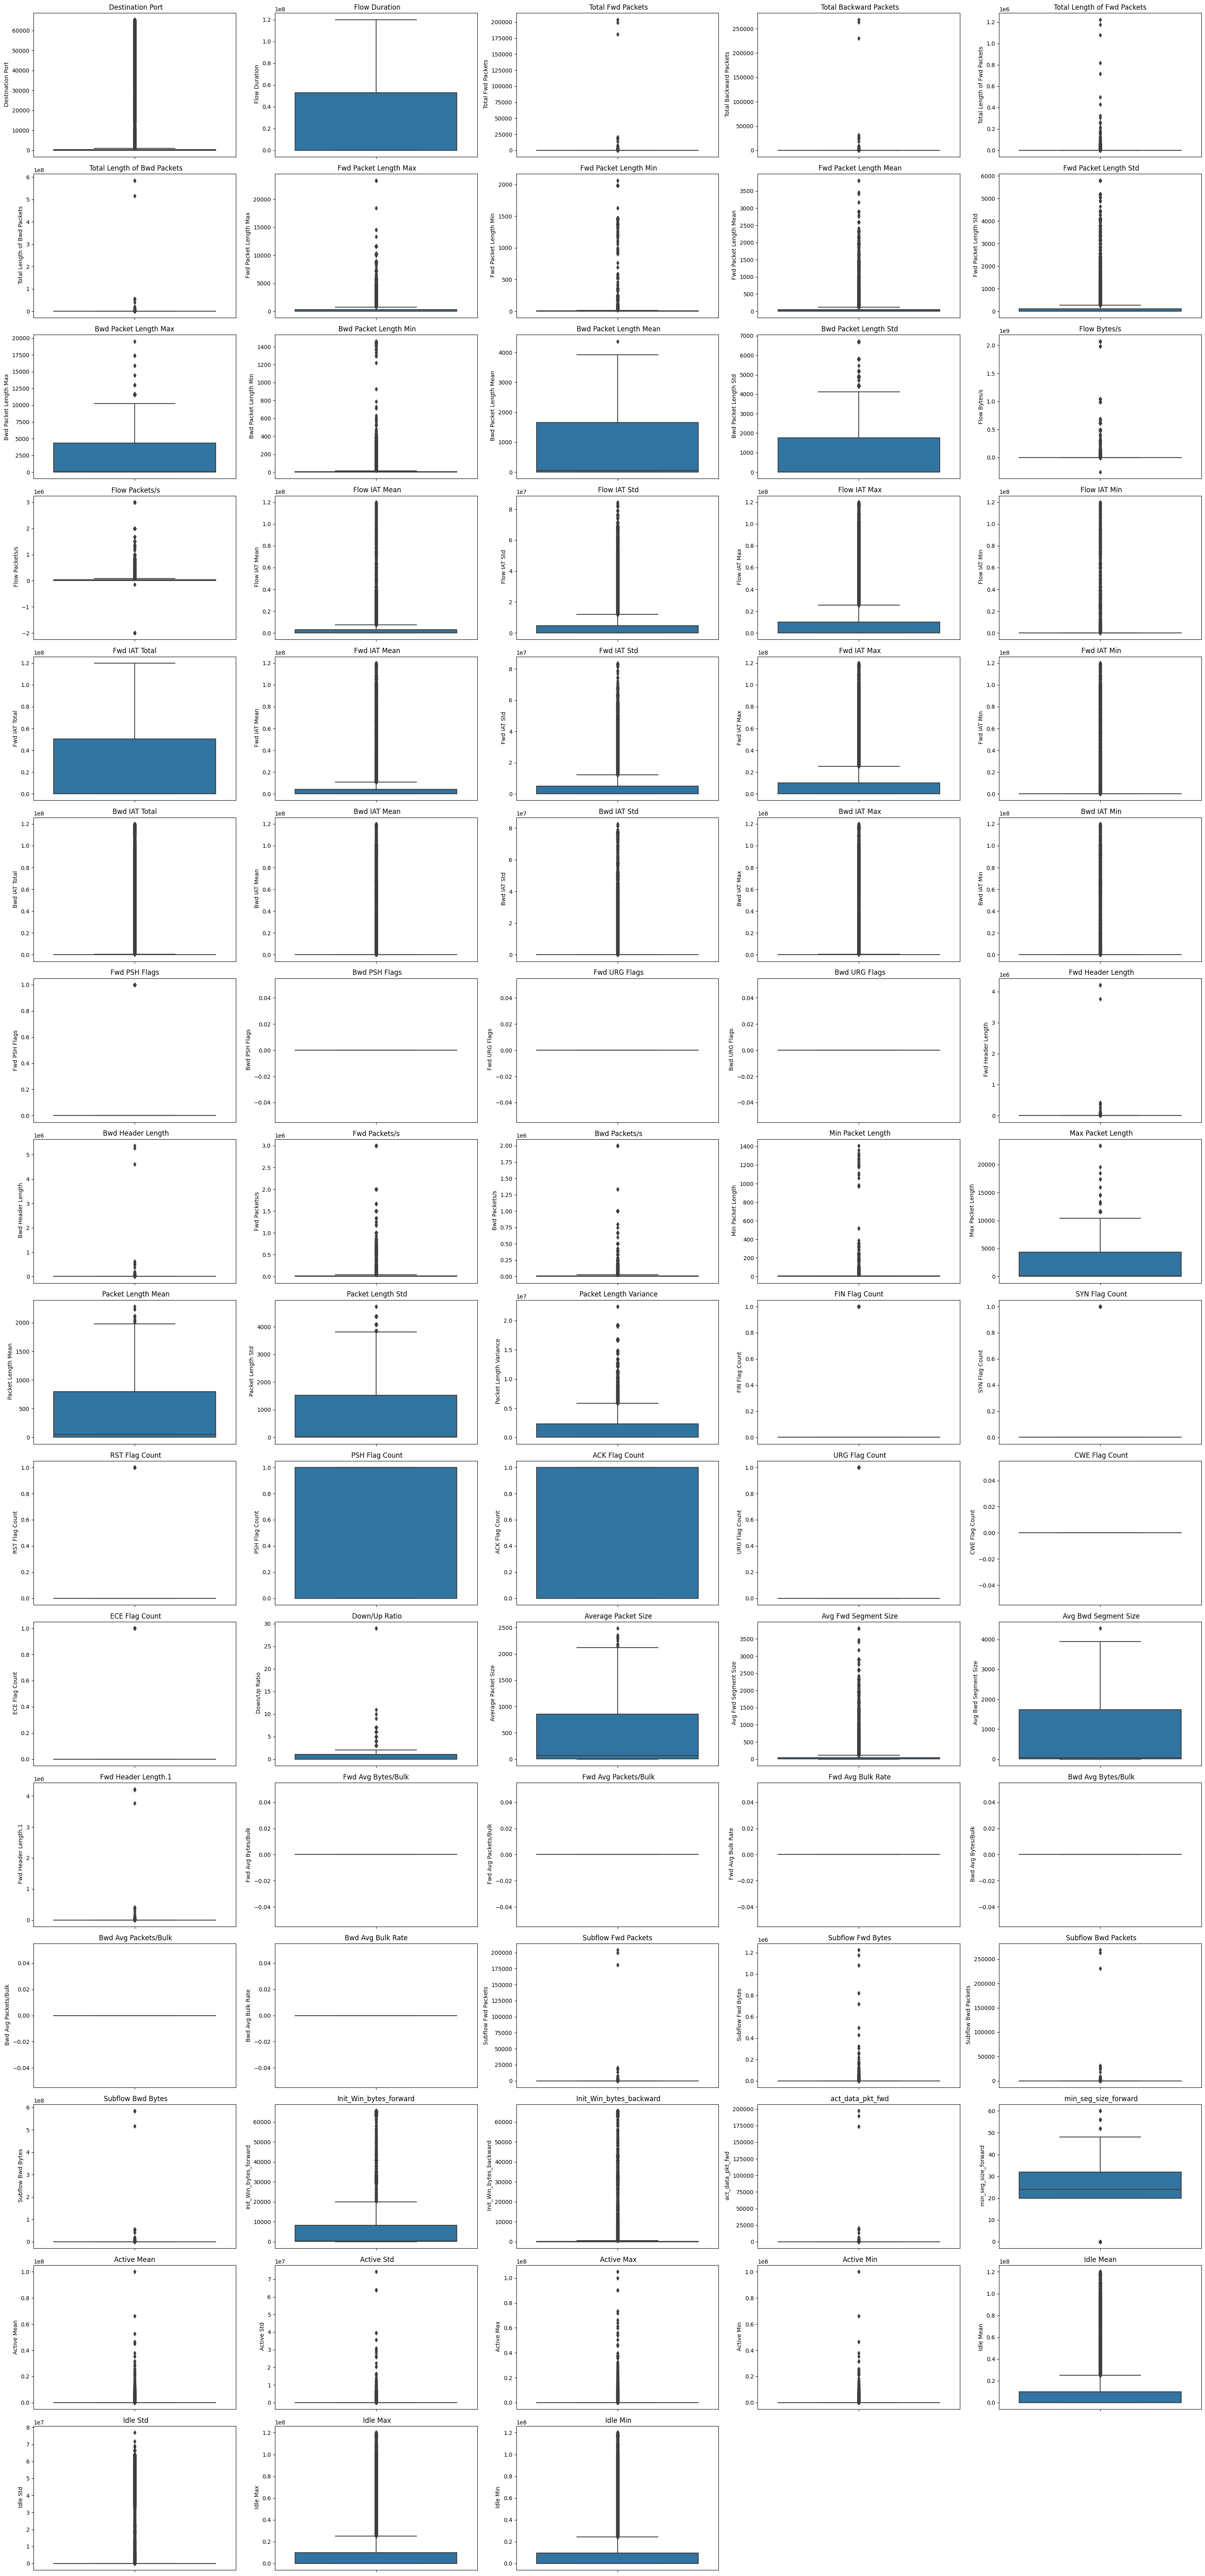

In [32]:
# Define the number of columns per row
num_cols = 5  # Change this based on your dataset
num_rows = -(-len(numerical_cols) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, num_rows * 4))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig('box_plots.png',dpi=300,bbox_inches='tight')
plt.show()

In [33]:
print(numerical_cols)

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [34]:
limits={}
for col in numerical_cols :
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    limits[col]=[lower_bound,upper_bound]
    X_train[col] = np.clip(X_train[col],lower_bound,upper_bound)
    X_test[col] = np.clip(X_test[col],lower_bound,upper_bound)

In [35]:
print(limits)

{' Destination Port': [-521.5, 1082.5], ' Flow Duration': [-79257178.5, 132095465.5], ' Total Fwd Packets': [-6.5, 13.5], ' Total Backward Packets': [-6.5, 13.5], 'Total Length of Fwd Packets': [-482.5, 809.5], ' Total Length of Bwd Packets': [-17377.5, 28978.5], ' Fwd Packet Length Max': [-452.5, 759.5], ' Fwd Packet Length Min': [-9.0, 15.0], ' Fwd Packet Length Mean': [-67.0, 117.0], ' Fwd Packet Length Std': [-162.5405046, 270.900841], 'Bwd Packet Length Max': [-6501.0, 10851.0], ' Bwd Packet Length Min': [-9.0, 15.0], ' Bwd Packet Length Mean': [-2469.6428564999997, 4132.071427499999], ' Bwd Packet Length Std': [-2640.895851, 4401.493085], 'Flow Bytes/s': [-187201.8645866875, 312321.1187520125], ' Flow Packets/s': [-48386.09101422312, 80644.55784053387], ' Flow IAT Mean': [-4404860.506375, 7341583.510625], ' Flow IAT Std': [-7222257.315374999, 12037095.525624998], ' Flow IAT Max': [-15299845.0, 25499907.0], ' Flow IAT Min': [-68.5, 119.5], 'Fwd IAT Total': [-75600000.0, 126000000.

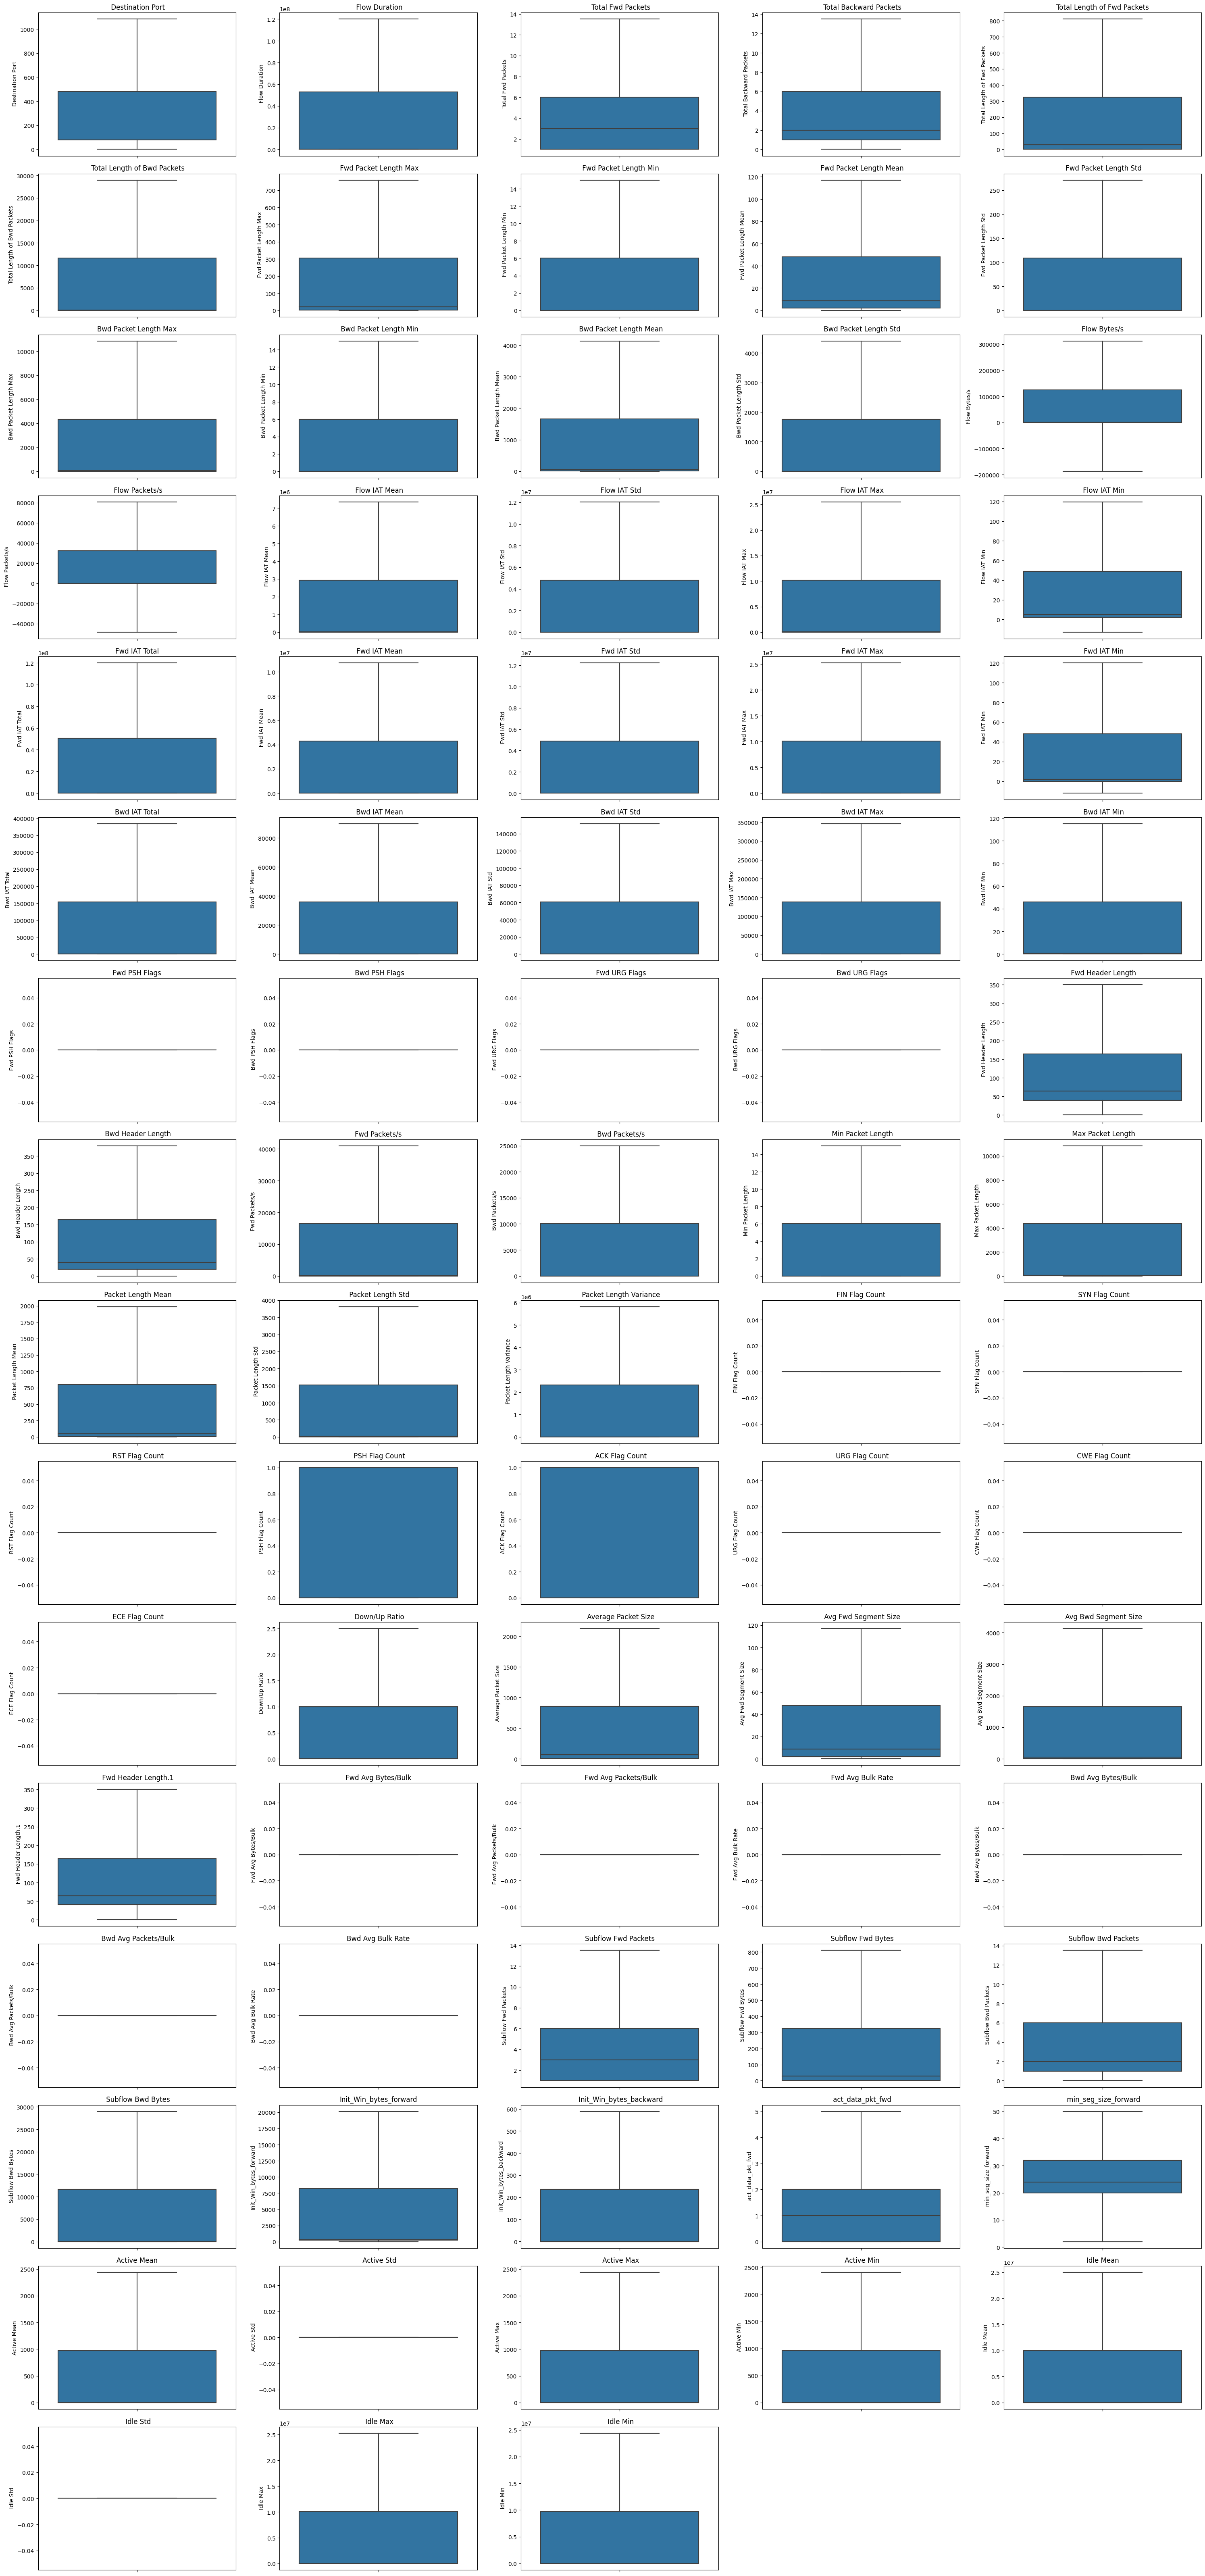

In [36]:
# Define the number of columns per row
num_cols = 5  # Change this based on your dataset
num_rows = -(-len(numerical_cols) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, num_rows * 4))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig('box_plot_outliers.png',dpi=300,bbox_inches='tight')
plt.show()

In [37]:
const_cols=[col for col in X_train.columns if len(np.unique(X_train[col]))==1]
print(const_cols)

['Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', ' Active Std', ' Idle Std']


In [38]:
X_train.drop(const_cols,axis=1,inplace=True)
X_test.drop(const_cols,axis=1,inplace=True)

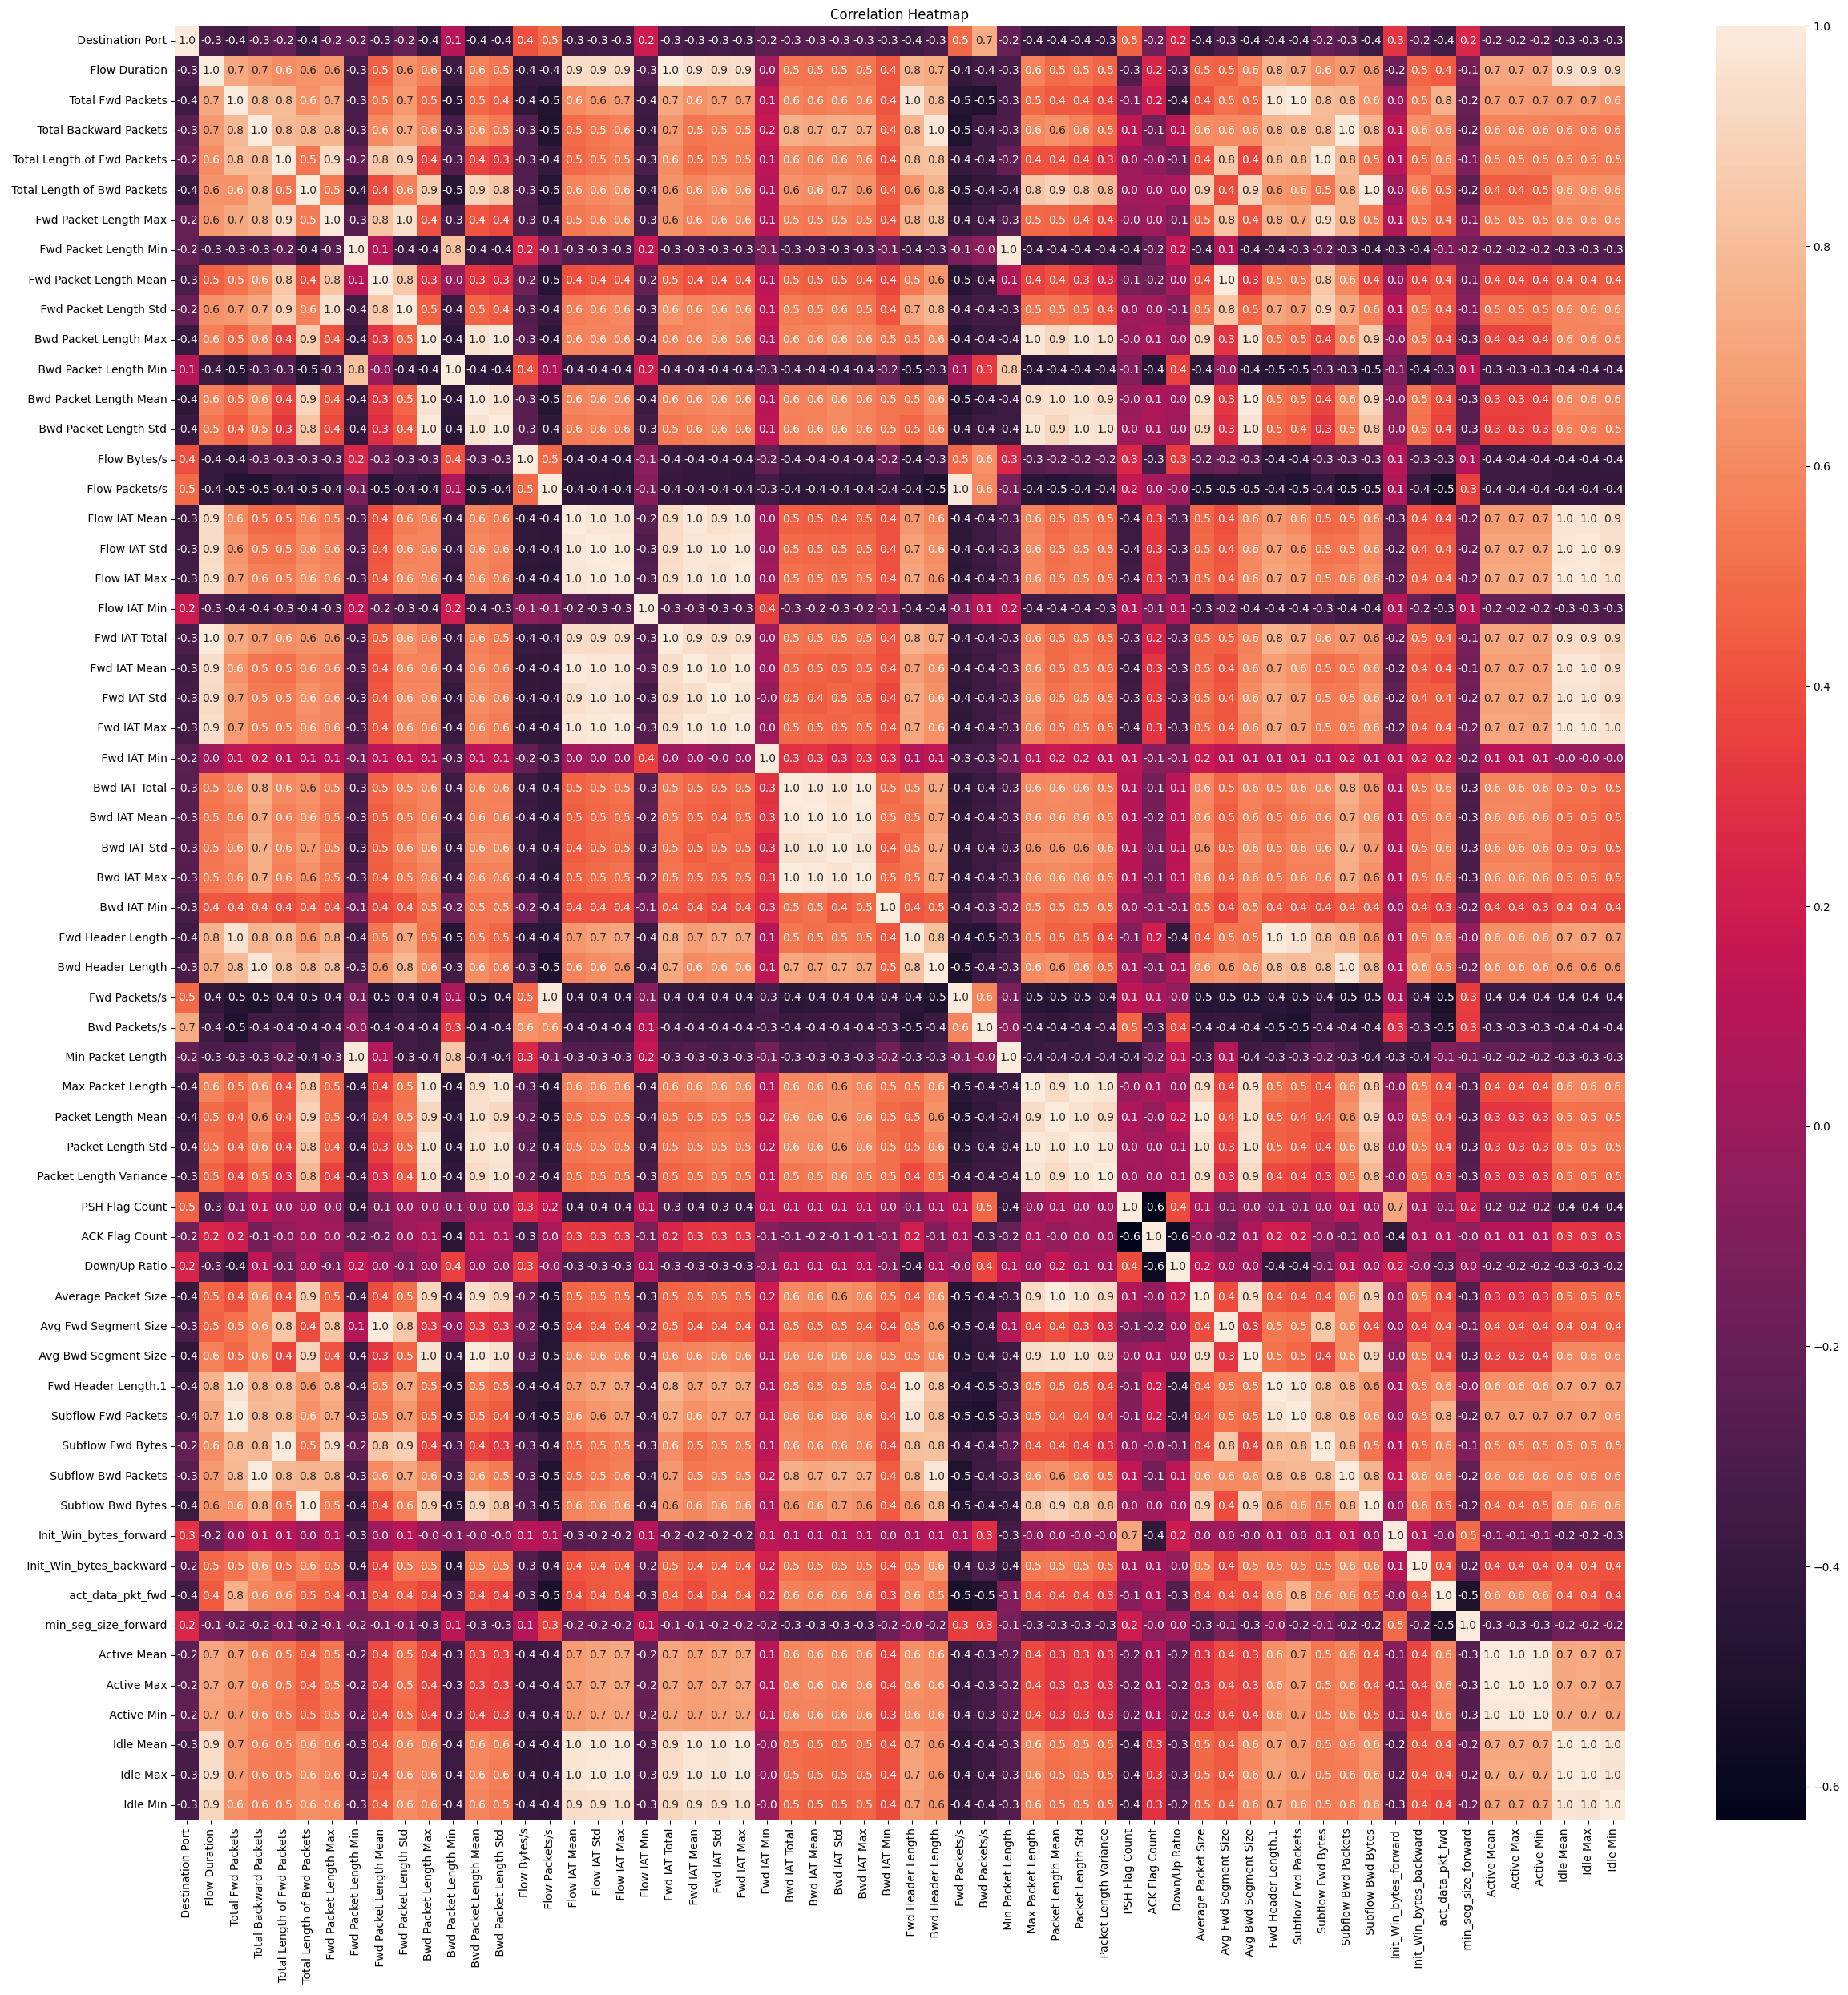

In [39]:
plt.figure(figsize=(25,25))
plt.title('Correlation Heatmap')
sns.heatmap(X_train.corr(),annot=True,fmt='.1f')
plt.tight_layout()
plt.savefig('heatmap.png',dpi=300,bbox_inches='tight')
plt.show()

In [40]:
X_train.corr()

Destination Port   Flow Duration  \
 Destination Port                      1.000000       -0.307051   
 Flow Duration                        -0.307051        1.000000   
 Total Fwd Packets                    -0.362868        0.724532   
 Total Backward Packets               -0.256827        0.658380   
Total Length of Fwd Packets           -0.207110        0.617279   
 Total Length of Bwd Packets          -0.382088        0.641514   
 Fwd Packet Length Max                -0.202369        0.647043   
 Fwd Packet Length Min                -0.206850       -0.317312   
 Fwd Packet Length Mean               -0.311200        0.459587   
 Fwd Packet Length Std                -0.205268        0.633801   
Bwd Packet Length Max                 -0.398833        0.566174   
 Bwd Packet Length Min                 0.104172       -0.373284   
 Bwd Packet Length Mean               -0.423010        0.571720   
 Bwd Packet Length Std                -0.391444        0.534743   
Flow Bytes/s                           0.402131       -0.392138   
 Flow Packets/s                        0.494561       -0.398517   
 Flow IAT Mean                        -0.348708        0.930674   
 Flow IAT Std                         -0.340824        0.934239   
 Flow IAT Max                         -0.340140        0.942248   
 Flow IAT Min                          0.178867       -0.292867   
Fwd IAT Total                         -0.306474        0.999441   
 Fwd IAT Mean                         -0.339533        0.945774   
 Fwd IAT Std                          -0.336374        0.924851   
 Fwd IAT Max                          -0.342048        0.943543   
 Fwd IAT Min                          -0.242949        0.016862   
Bwd IAT Total                         -0.260939        0.534679   
 Bwd IAT Mean                         -0.258387        0.524852   
 Bwd IAT Std                          -0.256811        0.526808   
 Bwd IAT Max                          -0.261158        0.535739   
 Bwd IAT Min                          -0.313894        0.424085   
 Fwd Header Length                    -0.361087        0.762717   
 Bwd Header Length                    -0.300172        0.726355   
Fwd Packets/s                          0.484638       -0.401864   
 Bwd Packets/s                         0.732211       -0.354799   
 Min Packet Length                    -0.205928       -0.312964   
 Max Packet Length                    -0.366733        0.575864   
 Packet Length Mean                   -0.390829        0.494597   
 Packet Length Std                    -0.368628        0.515134   
 Packet Length Variance               -0.349814        0.468873   
 PSH Flag Count                        0.459787       -0.288874   
 ACK Flag Count                       -0.162525        0.245631   
 Down/Up Ratio                         0.246587       -0.255430   
 Average Packet Size                  -0.390382        0.471687   
 Avg Fwd Segment Size                 -0.311200        0.459587   
 Avg Bwd Segment Size                 -0.423010        0.571720   
 Fwd Header Length.1                  -0.361087        0.762717   
Subflow Fwd Packets                   -0.362868        0.724532   
 Subflow Fwd Bytes                    -0.207110        0.617279   
 Subflow Bwd Packets                  -0.256827        0.658380   
 Subflow Bwd Bytes                    -0.382088        0.641514   
Init_Win_bytes_forward                 0.307578       -0.184457   
 Init_Win_bytes_backward              -0.215296        0.477160   
 act_data_pkt_fwd                     -0.350252        0.436922   
 min_seg_size_forward                  0.249211       -0.136831   
Active Mean                           -0.229892        0.712916   
 Active Max                           -0.229903        0.712964   
 Active Min                           -0.228999        0.706176   
Idle Mean                             -0.325977        0.942501   
 Idle Max                             -0.326298        0.943026   
 Idle Min  

In [41]:
X_train.shape

(640688, 60)

In [42]:
numerical_cols=[col for col in X_train.columns if X_train[col].dtype in ['int64','float64']]
corr_features=set()
threshold=0.95
corr_matrix= X_train[numerical_cols].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if i not in corr_features and j not in corr_features:
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                corr_features.add(colname)
print(corr_features)

{' Fwd Header Length.1', ' Subflow Bwd Packets', ' Flow IAT Std', ' Fwd IAT Mean', ' Bwd IAT Max', ' Avg Bwd Segment Size', ' Active Min', ' Subflow Fwd Bytes', 'Fwd Packets/s', ' Bwd IAT Mean', ' Fwd Header Length', 'Fwd IAT Total', ' Fwd Packet Length Std', ' Subflow Bwd Bytes', ' Max Packet Length', 'Idle Mean', ' Min Packet Length', ' Avg Fwd Segment Size', ' Bwd Packet Length Mean', ' Bwd IAT Std', ' Active Max', ' Average Packet Size', ' Fwd IAT Std', ' Fwd IAT Max', ' Idle Min', ' Bwd Header Length', ' Bwd Packet Length Std', ' Flow IAT Max', 'Subflow Fwd Packets', ' Packet Length Mean', ' Idle Max', ' Packet Length Std', ' Packet Length Variance'}


In [43]:
len(corr_features)

33

In [44]:
X_train.drop(corr_features,axis=1,inplace=True)
X_test.drop(corr_features,axis=1,inplace=True)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [46]:
X_train = scaler.fit_transform(X_train)

In [47]:
X_test = scaler.transform(X_test)

In [48]:
joblib.dump(scaler,'StandardScaler.pkl')

['StandardScaler.pkl']

In [49]:
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
Y_train=pd.DataFrame(Y_train)
Y_test=pd.DataFrame(Y_test)
X_train.to_csv('X_train_initial.csv')
X_test.to_csv('X_test_initial.csv')
Y_train.to_csv('Y_train_initial.csv')
Y_test.to_csv('Y_test_initial.csv')

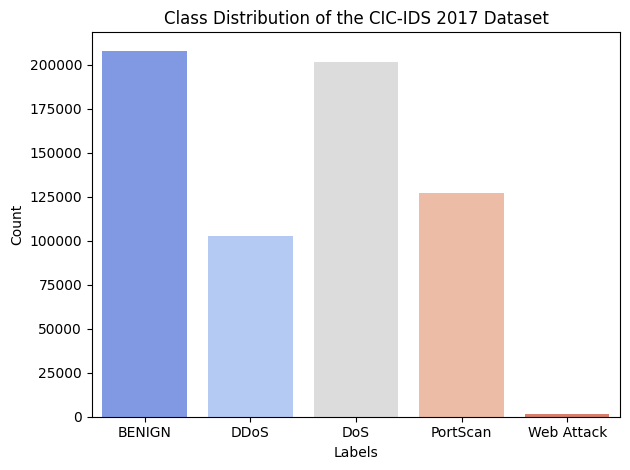

In [50]:
plt.title('Class Distribution of the CIC-IDS 2017 Dataset')
ax=sns.countplot(x=' Label',data=Y_train,palette='coolwarm')
plt.xlabel('Labels')
plt.ylabel('Count')
ax.set_xticklabels(classes)
plt.tight_layout()
plt.savefig('before_smote.png',dpi=300,bbox_inches='tight')
plt.show()

In [51]:
from imblearn.over_sampling import SMOTE
Smote = SMOTE(random_state=42)
X_train_smote , y_train_smote = Smote.fit_resample(X_train,Y_train)

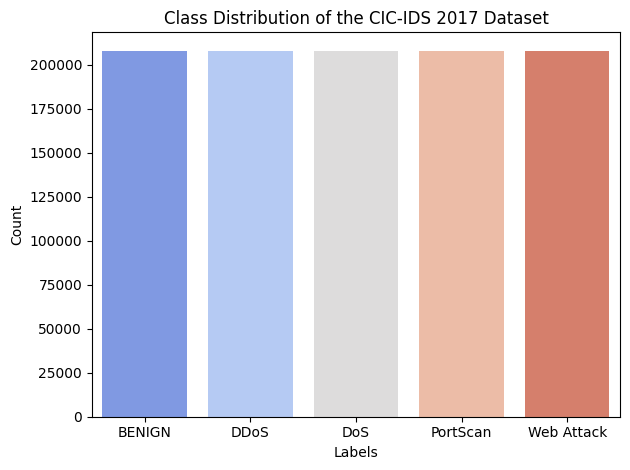

In [52]:
plt.title('Class Distribution of the CIC-IDS 2017 Dataset')
ax=sns.countplot(x=' Label',data=y_train_smote,palette='coolwarm')
plt.xlabel('Labels')
plt.ylabel('Count')
ax.set_xticklabels(classes)
plt.tight_layout()
plt.savefig('after_smote.png',dpi=300,bbox_inches='tight')
plt.show()

In [53]:
X_train_smote_df =pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_test_smote_df =pd.DataFrame(X_test)
y_test_smote_df = pd.DataFrame(Y_test)

X_train_smote_df.to_csv("X_train_smote.csv")
y_train_smote_df.to_csv("Y_train_smote.csv")
X_test_smote_df.to_csv("X_test_smote.csv")
y_test_smote_df.to_csv("Y_test_smote.csv")

In [3]:
X_train_smote_df=pd.read_csv("X_train_smote.csv")
y_train_smote_df=pd.read_csv("Y_train_smote.csv")
X_test_smote_df=pd.read_csv("X_test_smote.csv")
y_test_smote_df=pd.read_csv("Y_test_smote.csv")

In [4]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras import mixed_precision

# --- Enable Mixed Precision (like torch.cuda.amp.autocast)
mixed_precision.set_global_policy('mixed_float16')

# --- Load tokenizer and model
model_name = '/kaggle/input/tiny-bert-model'
print(f'Using device: {"GPU" if tf.config.list_physical_devices("GPU") else "CPU"}')
strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

Using device: GPU


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'fit_denses.0.bias', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.1.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.3.bias', 'fit_denses.1.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.4.weight', 'fit_denses.4.bias', 'fit_denses.0.weight', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificatio

In [56]:
X_traindf=pd.read_csv("X_train_smote.csv")
y_traindf=pd.read_csv("Y_train_smote.csv")
X_testdf=pd.read_csv("X_test_smote.csv")
y_testdf=pd.read_csv("Y_test_smote.csv")

In [57]:
import torch
from tqdm import tqdm

In [58]:
import pandas as pd

# Assuming X_train and X_test are already split
def convert_to_text(df):
    return df.apply(lambda row: ' '.join([f"{col}: {str(row[col])}" for col in df.columns]), axis=1)

# Convert each row in train and_t test sets to text
X_train_text = convert_to_text(X_traindf)
X_test_text = convert_to_text(X_testdf)

In [59]:
def extract_bert_features(texts, batch_size=128):
    all_embeddings = []
    texts = texts.tolist()

    for j, i in enumerate(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch
        encoded_input = tokenizer(batch_texts,
                                  padding=True,
                                  truncation=True,
                                  return_tensors='tf',
                                  max_length=512)

        # Enable mixed precision using tf.function for better graph execution
        @tf.function
        def forward_pass(inputs):
            outputs = bert_model(inputs, training=False)
            return outputs.last_hidden_state[:, 0, :]  # CLS token

        # Forward pass
        embeddings = forward_pass(encoded_input)
        embeddings = tf.cast(embeddings, tf.float32)  # Downcast back to float32 for numerical stability
        all_embeddings.append(embeddings.numpy())

            #print(f'{j}. Device: {"GPU" if tf.config.list_physical_devices("GPU") else "CPU"}')

    return np.vstack(all_embeddings)
# Assuming X_train_text and X_test_text are Pandas Series containing text data
X_train_bert = pd.DataFrame(extract_bert_features(X_train_text))
X_test_bert = pd.DataFrame(extract_bert_features(X_test_text))

# Save to CSV files
X_train_bert.to_csv("X_train_bert.csv", index=False)
X_test_bert.to_csv("X_test_bert.csv", index=False)

# Print shapes of the extracted features
print("Shape of Train Features:", X_train_bert.shape)
print("Shape of Test Features:", X_test_bert.shape)

<ipython-input-59-43e5a7a14e22>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(),torch.cuda.amp.autocast():


Shape of Train Features: (1040000, 312)
Shape of Test Features: (160172, 312)


In [60]:
y_traindf.head()

Unnamed: 0   Label
0           0       3
1           1       1
2           2       3
3           3       2
4           4       1

In [4]:
#X_train_bert=pd.read_csv(r'/kaggle/working/X_train_bert.csv')
X_test_bert=pd.read_csv(r'/kaggle/working/X_test_bert.csv')
#y_traindf=pd.read_csv(r'/kaggle/working/Y_train_smote.csv')
y_testdf=pd.read_csv(r'/kaggle/working/Y_test_smote.csv')

In [5]:
X_train_bert

0         1         2         3         4         5         6  \
0       -0.488291  0.319896 -0.022670  0.162296  0.183033 -0.257659 -0.059205   
1       -0.513029  0.340489 -0.025319  0.149873  0.187184 -0.260969 -0.050859   
2       -0.453015  0.351294 -0.002633  0.134273  0.157416 -0.189068 -0.050416   
3       -0.505206  0.341571 -0.023546  0.144942  0.176364 -0.235493 -0.046175   
4       -0.503155  0.335220 -0.024742  0.146505  0.187084 -0.258091 -0.060626   
...           ...       ...       ...       ...       ...       ...       ...   
1039995 -0.496085  0.345156 -0.020126  0.152823  0.184091 -0.250505 -0.058308   
1039996 -0.500188  0.346472 -0.018089  0.151959  0.189556 -0.260591 -0.062367   
1039997 -0.498990  0.349517 -0.016841  0.149862  0.189887 -0.260138 -0.060235   
1039998 -0.502158  0.350161 -0.024622  0.146262  0.181611 -0.248405 -0.051762   
1039999 -0.503784  0.352966 -0.019459  0.149457  0.188626 -0.237869 -0.033473   

                7         8         9  ...       302       303       304  \
0        0.283092 -0.057194 -0.066204  ...  0.042711  0.488603  0.274665   
1        0.278137 -0.062288 -0.068080  ...  0.043476  0.481525  0.263043   
2        0.286265 -0.072814 -0.051779  ...  0.140902  0.483933  0.268236   
3        0.289738 -0.054057 -0.055816  ...  0.049549  0.476119  0.270412   
4        0.286449 -0.059951 -0.065008  ...  0.059952  0.489018  0.268433   
...           ...       ...       ...  ...       ...       ...       ...   
1039995  0.295066 -0.066006 -0.074145  ...  0.052168  0.498765  0.260629   
1039996  0.291902 -0.060426 -0.067453  ...  0.048714  0.501139  0.266429   
1039997  0.290652 -0.060954 -0.072153  ...  0.050509  0.497974  0.266573   
1039998  0.300611 -0.070574 -0.071379  ...  0.057544  0.493254  0.262163   
1039999  0.291045 -0.072229 -0.064645  ...  0.055104  0.480997  0.257284   

              305       306       307       308       309       310       311  
0       -0.099059  0.368355  0.074706  0.169508 -0.162144  0.355135 -0.097049  
1       -0.086206  0.357767  0.055529  0.165031 -0.162428  0.369189 -0.086353  
2       -0.104136  0.346714  0.079565  0.146946 -0.115577  0.329701 -0.066282  
3       -0.084551  0.359658  0.060629  0.170539 -0.156241  0.369237 -0.089797  
4       -0.076228  0.361914  0.059000  0.161778 -0.159074  0.369614 -0.091798  
...           ...       ...       ...       ...       ...       ...       ...  
1039995 -0.081987  0.355387  0.058954  0.158813 -0.159534  0.359442 -0.096727  
1039996 -0.081465  0.356498  0.052719  0.159115 -0.162513  0.365308 -0.098959  
1039997 -0.079147  0.357016  0.054628  0.159287 -0.162923  0.363300 -0.101301  
1039998 -0.077384  0.349173  0.060700  0.156175 -0.156572  0.357008 -0.088625  
1039999 -0.069693  0.358341  0.062007  0.159654 -0.155392  0.357410 -0.095491  

[1040000 rows x 312 columns]

In [6]:
X_train_bert.shape,X_test_bert.shape,y_traindf.shape,y_testdf.shape

((1040000, 312), (160172, 312), (1040000, 2), (160172, 2))

In [5]:
y_traindf.drop('Unnamed: 0',axis=1,inplace=True)
y_testdf.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler2=StandardScaler()
X_train_bert=scaler2.fit_transform(X_train_bert)
X_test_bert=scaler2.transform(X_test_bert)
joblib.dump(scaler2,'StandardScaler2.pkl')

['StandardScaler2.pkl']

In [6]:
scaler2=joblib.load(r'/kaggle/working/StandardScaler2.pkl')
X_test_bert=scaler2.transform(X_test_bert)

In [7]:
le=joblib.load('/kaggle/working/label_encoder.pkl')
classes=le.inverse_transform([0,1,2,3,4])

In [10]:
classes

array(['BENIGN', 'DDoS', 'DoS', 'PortScan', 'Web Attack'], dtype=object)

In [11]:
import tensorflow as tf
from tensorflow import keras

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    model=keras.Sequential([
        keras.layers.Dense(256,input_shape=(312,),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5,activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(clipnorm=1.0),
        metrics=['Accuracy']
    )
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_Accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.fit(X_train_bert,y_traindf,epochs=100,batch_size=8192,validation_data=(X_test_bert,y_testdf),callbacks=[early_stopping])
pred=model.predict(X_test_bert)
pred=[np.argmax(i) for i in pred]
model.save('mlp_multiclass.h5')

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Accuracy: 0.9953 - loss: 0.0160 - val_Accuracy: 0.9960 - val_loss: 0.0133
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Accuracy: 0.9957 - loss: 0.0151 - val_Accuracy: 0.9958 - val_loss: 0.0140
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Accuracy: 0.9958 - loss: 0.0148 - val_Accuracy: 0.9962 - val_loss: 0.0128
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Accuracy: 0.9957 - loss: 0.0147 - val_Accuracy: 0.9963 - val_loss: 0.0132
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Accuracy: 0.9957 - loss: 0.0148 - val_Accuracy: 0.9961 - val_loss: 0.0138
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - Accuracy: 0.9958 - loss: 0.0146 - val_Accuracy: 0.9960 - val_loss: 0.0131
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Accuracy: 0.9957 - loss: 0.0149 - val_Accuracy: 0.9962 - val_loss: 0.0127
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Accuracy: 0.9958 - loss: 0.0146 - 

In [15]:
from sklearn.metrics import accuracy_score,classification_report
print(f'Accuracy: {accuracy_score(y_testdf,pred)*100:.2f}%')
print('Classification Report:\n',classification_report(y_testdf,pred,target_names=classes))

Accuracy: 99.69%
Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00     52000
        DDoS       1.00      1.00      1.00     25605
         DoS       1.00      1.00      1.00     50345
    PortScan       1.00      1.00      1.00     31786
  Web Attack       0.63      0.97      0.76       436

    accuracy                           1.00    160172
   macro avg       0.93      0.99      0.95    160172
weighted avg       1.00      1.00      1.00    160172



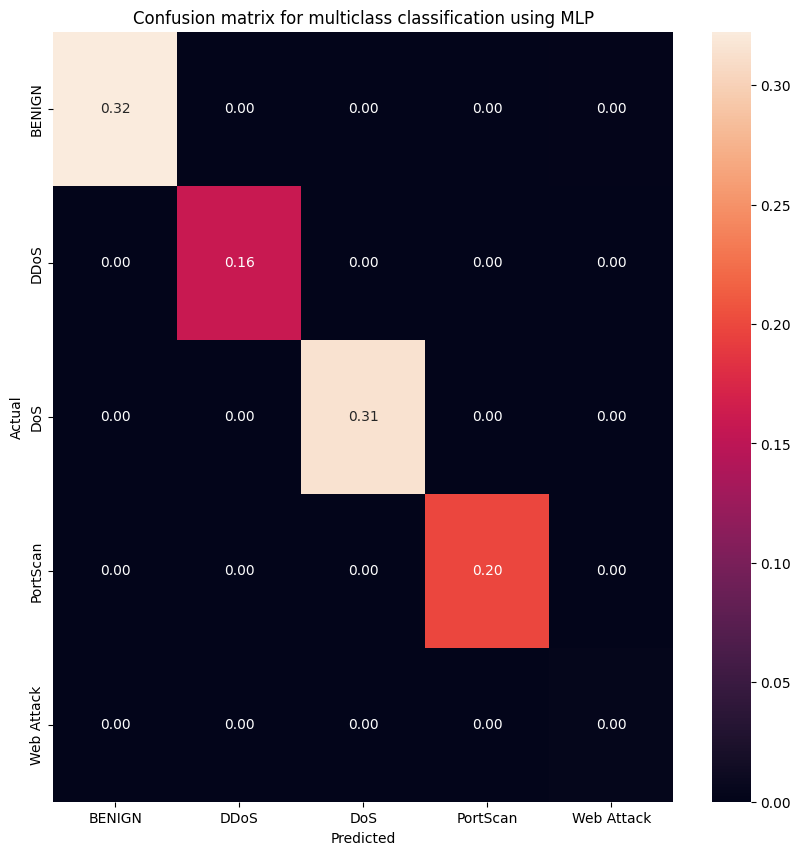

In [16]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.title('Confusion matrix for multiclass classification using MLP')
ax=sns.heatmap(confusion_matrix(y_testdf,pred)/len(y_testdf),annot=True,fmt='.2f',xticklabels=classes,yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Conv1D,Dense,Dropout,BatchNormalization,MaxPooling1D,Flatten
with strategy.scope():
    cnn=keras.Sequential([
        Reshape((312,1),input_shape=(312,)),
        
        Conv1D(64,kernel_size=5,activation='relu'),
        MaxPooling1D(pool_size=2),
    
        Flatten(),
        Dense(64,activation='relu'),
        Dropout(0.5),
        Dense(16,activation='relu'),
        Dense(5,activation='softmax')
    ])
    cnn.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0),
        metrics=['Accuracy']
    )
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_Accuracy',
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
cnn.fit(X_train_bert,y_traindf,epochs=100,batch_size=4096,validation_data=(X_test_bert,y_testdf),callbacks=[early_stopping])
pred_cnn=cnn.predict(X_test_bert)
pred_cnn=[np.argmax(i) for i in pred_cnn]
cnn.save('cnn_multiclass.h5')

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - Accuracy: 0.8050 - loss: 0.5419 - val_Accuracy: 0.9722 - val_loss: 0.0891
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9650 - loss: 0.1166 - val_Accuracy: 0.9792 - val_loss: 0.0658
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - Accuracy: 0.9719 - loss: 0.0909 - val_Accuracy: 0.9820 - val_loss: 0.0540
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9758 - loss: 0.0788 - val_Accuracy: 0.9837 - val_loss: 0.0481
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9776 - loss: 0.0714 - val_Accuracy: 0.9854 - val_loss: 0.0438
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9789 - loss: 0.0676 - val_Accuracy: 0.9847 - val_loss: 0.0459
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - Accuracy: 0.9796 - loss: 0.0654 - val_Accuracy: 0.9857 - val_loss: 0.0426
Epoch 8/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9808 - loss: 0

In [23]:
from sklearn.metrics import accuracy_score,classification_report
print(f'Accuracy: {accuracy_score(y_testdf,pred_cnn)*100:.2f}%')
print('Classification Report:\n',classification_report(y_testdf,pred_cnn,target_names=classes))

Accuracy: 99.00%
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.99     52000
        DDoS       1.00      1.00      1.00     25605
         DoS       0.99      0.99      0.99     50345
    PortScan       1.00      1.00      1.00     31786
  Web Attack       0.45      0.96      0.61       436

    accuracy                           0.99    160172
   macro avg       0.88      0.98      0.92    160172
weighted avg       0.99      0.99      0.99    160172



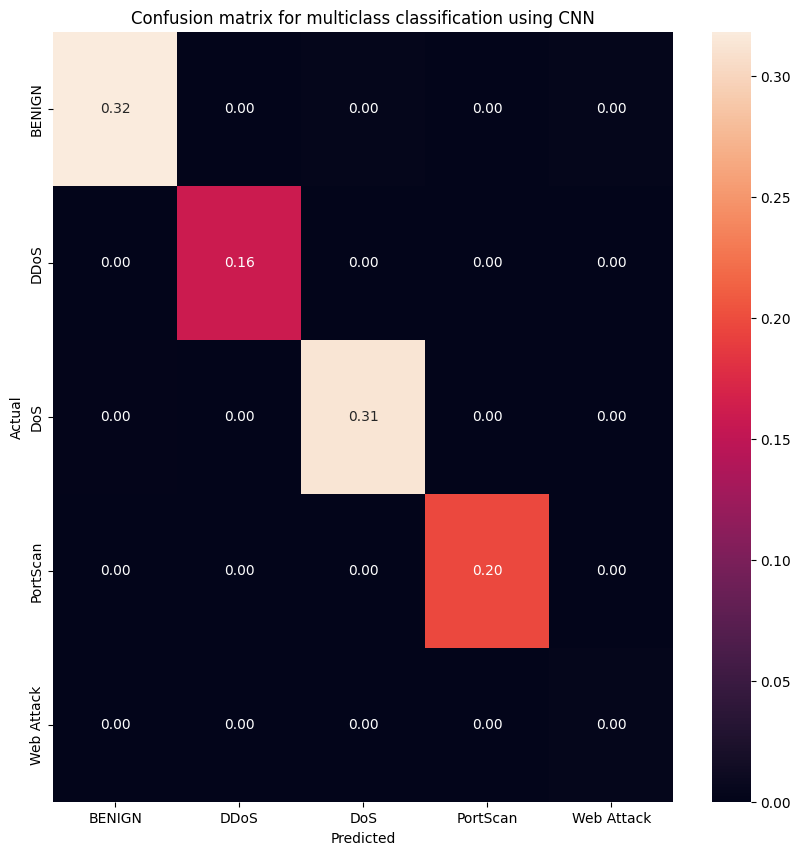

In [24]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.title('Confusion matrix for multiclass classification using CNN')
ax=sns.heatmap(confusion_matrix(y_testdf,pred_cnn)/len(y_testdf),annot=True,fmt='.2f',xticklabels=classes,yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train_bert,y_traindf)
pred_knn=knn.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_testdf,pred_knn))
print('Classification Report:\n',classification_report(y_testdf,pred_knn,target_names=classes))
joblib.dump(knn,'knn_multiclass.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.9711372774267663
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.99      0.94      0.96     52000
        DDoS       0.95      0.99      0.97     25605
         DoS       0.97      0.98      0.97     50345
    PortScan       1.00      1.00      1.00     31786
  Web Attack       0.25      0.99      0.40       436

    accuracy                           0.97    160172
   macro avg       0.83      0.98      0.86    160172
weighted avg       0.98      0.97      0.97    160172



['knn_multiclass.pkl']

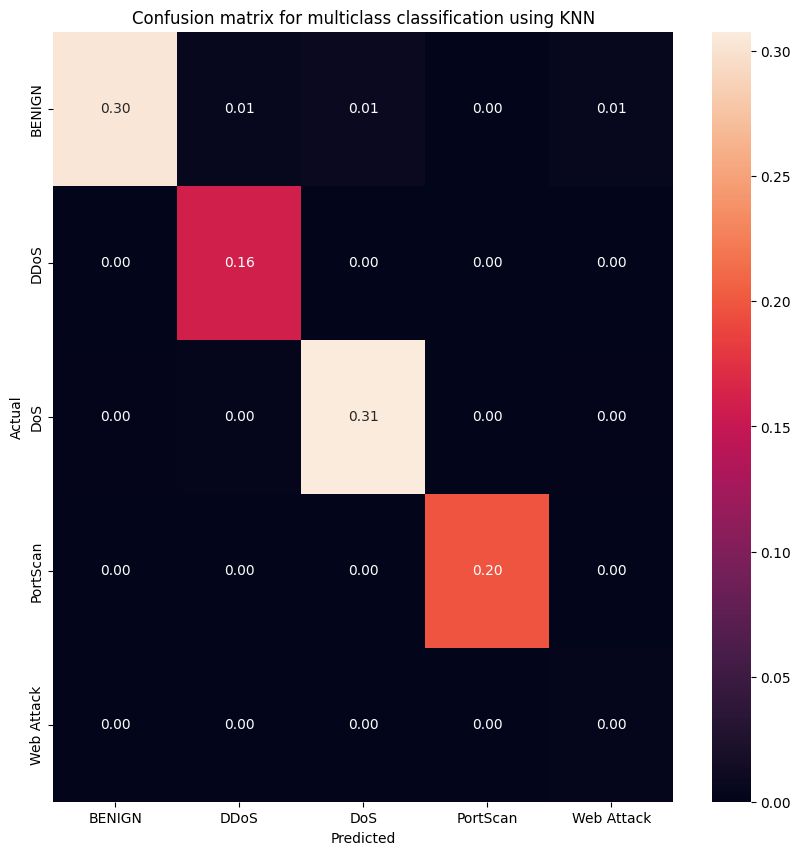

In [43]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.title('Confusion matrix for multiclass classification using KNN')
ax=sns.heatmap(confusion_matrix(y_testdf,pred_knn)/len(y_testdf),annot=True,fmt='.2f',xticklabels=classes,yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_bert,y_traindf)
pred_lr=lr.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_testdf,pred_lr))
print('Classification Report:\n',classification_report(y_testdf,pred_lr,target_names=classes))
joblib.dump(lr,'logistic_multiclass.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9752953075443898
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.98      0.96      0.97     52000
        DDoS       0.98      0.99      0.98     25605
         DoS       0.98      0.98      0.98     50345
    PortScan       0.99      1.00      0.99     31786
  Web Attack       0.28      0.88      0.42       436

    accuracy                           0.98    160172
   macro avg       0.84      0.96      0.87    160172
weighted avg       0.98      0.98      0.98    160172



['logistic_multiclass.pkl']

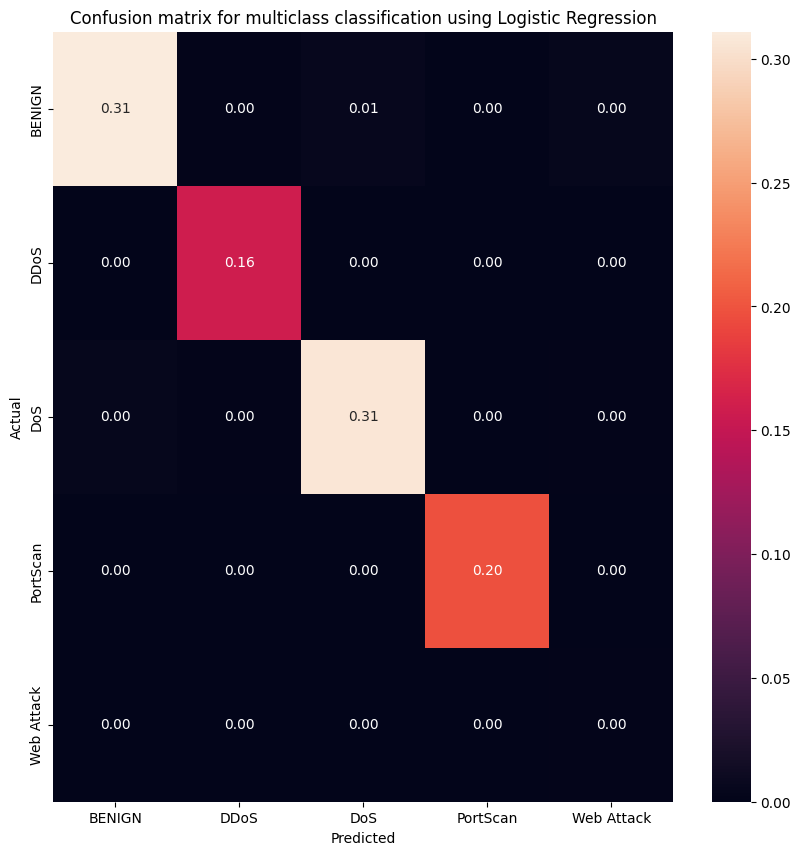

In [26]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.title('Confusion matrix for multiclass classification using Logistic Regression')
ax=sns.heatmap(confusion_matrix(y_testdf,pred_lr)/len(y_testdf),annot=True,fmt='.2f',xticklabels=classes,yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth=10)
dt.fit(X_train_bert,y_traindf)
pred_dt=dt.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_testdf,pred_dt))
print('Classification Report:\n',classification_report(y_testdf,pred_dt,target_names=classes))
joblib.dump(dt,'dt.pkl')

Accuracy: 0.8038858227405539
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.81      0.74      0.78     52000
        DDoS       0.68      0.79      0.73     25605
         DoS       0.82      0.77      0.80     50345
    PortScan       0.97      0.96      0.97     31786
  Web Attack       0.09      0.80      0.16       436

    accuracy                           0.80    160172
   macro avg       0.67      0.81      0.69    160172
weighted avg       0.82      0.80      0.81    160172



['dt.pkl']

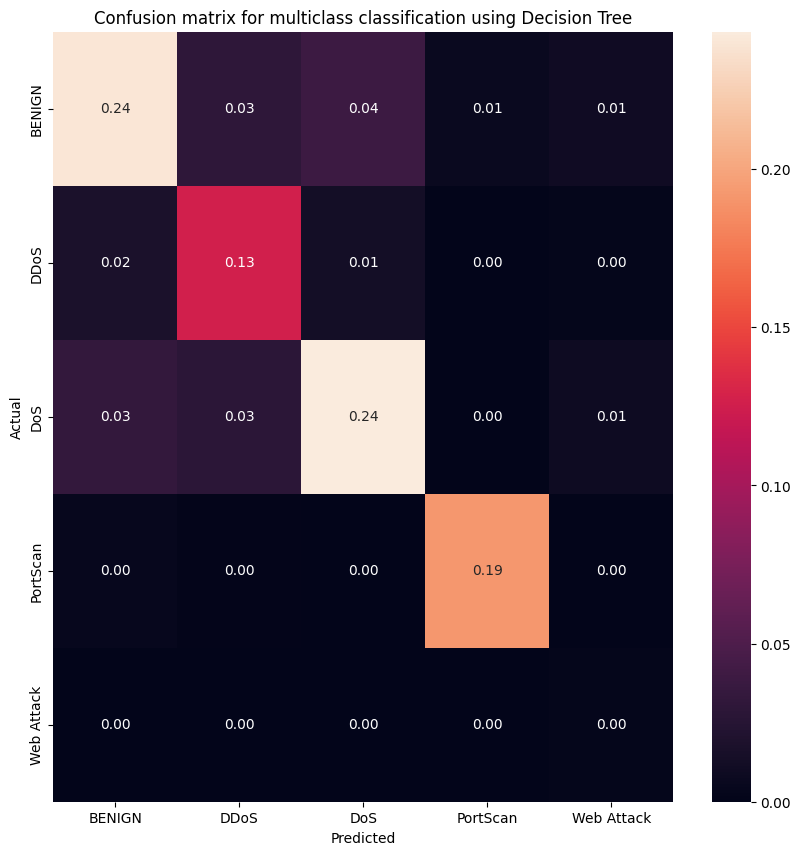

In [28]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
plt.title('Confusion matrix for multiclass classification using Decision Tree')
ax=sns.heatmap(confusion_matrix(y_testdf,pred_dt)/len(y_testdf),annot=True,fmt='.2f',xticklabels=classes,yticklabels=classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [9]:
mlp_multi=tf.keras.models.load_model(r'/kaggle/working/mlp_multiclass.h5')
pred_mlp=mlp_multi.predict(X_test_bert)
pred_mlp=[np.argmax(i) for i in pred_mlp]

cnn_multi=tf.keras.models.load_model(r'/kaggle/working/cnn_multiclass.h5')
pred_cnn=cnn_multi.predict(X_test_bert)
pred_cnn=[np.argmax(i) for i in pred_cnn]

lr_multi=joblib.load(r'/kaggle/working/logistic_multiclass.pkl')
pred_lr=lr_multi.predict(X_test_bert)

dt_multi=joblib.load(r'/kaggle/working/dt.pkl')
pred_dt=dt_multi.predict(X_test_bert)

knn_multi=joblib.load(r'/kaggle/working/knn_multiclass.pkl')
pred_knn=knn_multi.predict(X_test_bert)

5006/5006 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5006/5006 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


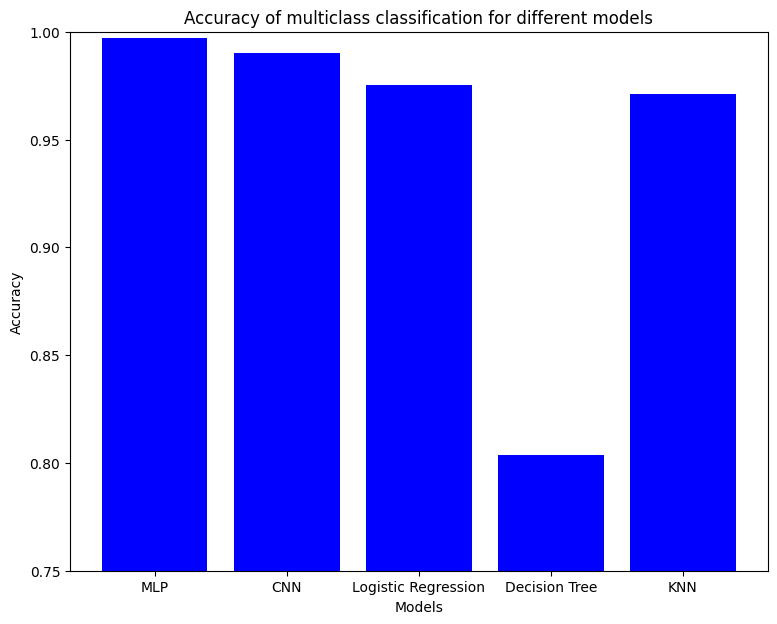

In [20]:
from sklearn.metrics import accuracy_score
models=['MLP','CNN','Logistic Regression','Decision Tree','KNN']
accuracies=[]
accuracies.append(accuracy_score(y_testdf,pred_mlp))
accuracies.append(accuracy_score(y_testdf,pred_cnn))
accuracies.append(accuracy_score(y_testdf,pred_lr))
accuracies.append(accuracy_score(y_testdf,pred_dt))
accuracies.append(accuracy_score(y_testdf,pred_knn))

plt.figure(figsize=(9,7))
plt.title('Accuracy of multiclass classification for different models')
plt.bar(models,accuracies,color='blue')
plt.ylim(0.75,1.0)
plt.yticks(np.arange(0.75,1.01,0.05))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.savefig('accuracy_multi.jpg',dpi=300,bbox_inches='tight')
plt.show()

5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


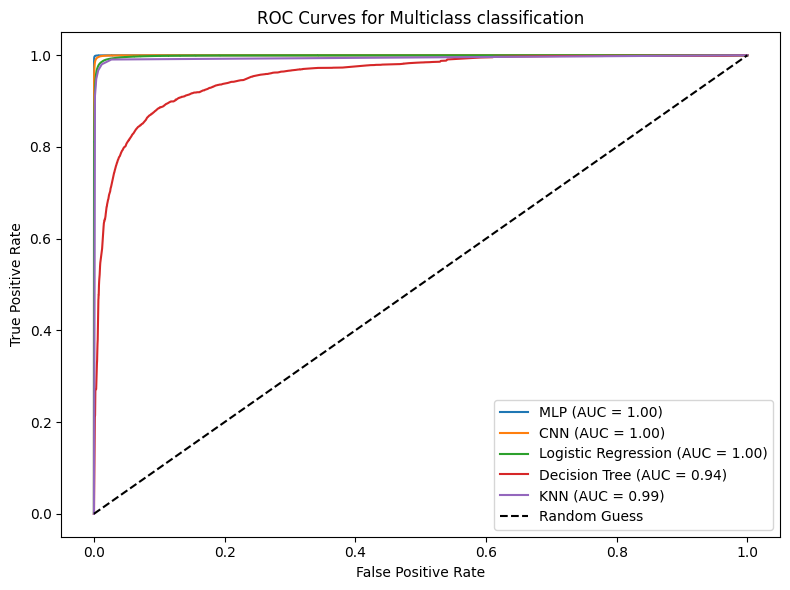

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,roc_auc_score


y_test_binarized = label_binarize(y_testdf, classes=[0,1,2,3,4])
n_classes = 5

mlp_multi=tf.keras.models.load_model(r'/kaggle/working/mlp_multiclass.h5')
cnn_multi=tf.keras.models.load_model(r'/kaggle/working/cnn_multiclass.h5')
lr_multi=joblib.load(r'/kaggle/working/logistic_multiclass.pkl')
dt_multi=joblib.load(r'/kaggle/working/dt.pkl')
knn_multi=joblib.load(r'/kaggle/working/knn_multiclass.pkl')

models = {
    'MLP': mlp_multi.predict(X_test_bert),
    'CNN': cnn_multi.predict(X_test_bert),
    'Logistic Regression': lr_multi.predict_proba(X_test_bert),
    'Decision Tree': dt_multi.predict_proba(X_test_bert),
    'KNN': knn_multi.predict_proba(X_test_bert)
}

# Plot setup
plt.figure(figsize=(8, 6))


for name, probs in models.items():
    try:
        # Check if each class has at least one positive sample
        # if np.all(np.sum(y_test_binarized, axis=0) == 0):
        #     print(f"[Warning] {name}: No positive samples in any class, skipping...")
        #     continue

        # Calculate macro AUC
        auc_score = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

        # Calculate ROC curve (flattened for macro average)
        fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), probs.ravel())

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

    except Exception as e:
        print(f"[Skipped] {name}: {e}")


# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass classification')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_multiclass.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
#y_train_temp=le.inverse_transform(y_traindf)
y_test_temp=le.inverse_transform(y_testdf)
#y_train_bin=np.array([0 if i=='BENIGN' else 1 for i in y_train_temp])
y_test_bin=np.array([0 if i=='BENIGN' else 1 for i in y_test_temp])
bin_classes=['BENIGN','ATTACK']

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
import tensorflow as tf
from tensorflow import keras

mlp_bin=keras.Sequential([
        keras.layers.Dense(256,input_shape=(312,),activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='sigmoid')
])
mlp_bin.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(clipnorm=1.0),
        metrics=['Accuracy']
)
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_Accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
mlp_bin.fit(X_train_bert,y_train_bin,epochs=100,batch_size=4096,validation_data=(X_test_bert,y_test_bin),callbacks=[early_stopping])
pred_mlp_bin=mlp_bin.predict(X_test_bert)
mlp_bin.save('mlp_bin.h5')

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - Accuracy: 0.8614 - loss: 0.3415 - val_Accuracy: 0.9701 - val_loss: 0.0963
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9806 - loss: 0.0704 - val_Accuracy: 0.9822 - val_loss: 0.0582
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9850 - loss: 0.0534 - val_Accuracy: 0.9864 - val_loss: 0.0451
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9876 - loss: 0.0443 - val_Accuracy: 0.9890 - val_loss: 0.0373
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9890 - loss: 0.0391 - val_Accuracy: 0.9894 - val_loss: 0.0348
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9899 - loss: 0.0355 - val_Accuracy: 0.9905 - val_loss: 0.0310
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9908 - loss: 0.0322 - val_Accuracy: 0.9909 - val_loss: 0.0286
Epoch 8/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.9911 - loss: 0.0304 - val_Ac

In [32]:
pred_mlp_bin=(pred_mlp_bin >=0.5).astype(int).flatten()
from sklearn.metrics import accuracy_score,classification_report
print(f'Accuracy: {accuracy_score(y_test_bin,pred_mlp_bin)*100:.2f}%')
print('Classification Report:\n',classification_report(y_test_bin,pred_mlp_bin,target_names=bin_classes))

Accuracy: 99.68%
Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99     52000
      ATTACK       1.00      1.00      1.00    108172

    accuracy                           1.00    160172
   macro avg       1.00      1.00      1.00    160172
weighted avg       1.00      1.00      1.00    160172



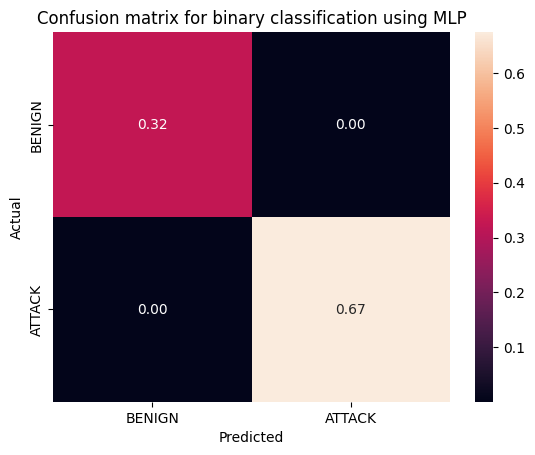

In [33]:
from sklearn.metrics import confusion_matrix
plt.title('Confusion matrix for binary classification using MLP')
ax=sns.heatmap(confusion_matrix(y_test_bin,pred_mlp_bin)/len(y_test_bin),annot=True,fmt='.2f',xticklabels=bin_classes,yticklabels=bin_classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Conv1D,Dense,Dropout,BatchNormalization,MaxPooling1D,Flatten
with strategy.scope():
    cnn_bin=keras.Sequential([
        Reshape((312,1),input_shape=(312,)),
        
        Conv1D(64,kernel_size=5,activation='relu'),
        MaxPooling1D(pool_size=2),
    
        Flatten(),
        Dense(64,activation='relu'),
        Dropout(0.5),
        Dense(16,activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    cnn_bin.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001,clipnorm=1.0),
        metrics=['Accuracy']
    )
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_Accuracy',
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
cnn_bin.fit(X_train_bert,y_train_bin,epochs=50,batch_size=4096,validation_data=(X_test_bert,y_test_bin),callbacks=[early_stopping])
pred_cnn_bin=cnn_bin.predict(X_test_bert)
pred_cnn_bin=(pred_cnn_bin >=0.5).astype(int).flatten()
cnn_bin.save('cnn_bin.h5')

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - Accuracy: 0.8834 - loss: 0.3088 - val_Accuracy: 0.9677 - val_loss: 0.1182
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - Accuracy: 0.9755 - loss: 0.1030 - val_Accuracy: 0.9784 - val_loss: 0.0693
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9799 - loss: 0.0715 - val_Accuracy: 0.9795 - val_loss: 0.0635
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9823 - loss: 0.0598 - val_Accuracy: 0.9804 - val_loss: 0.0575
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - Accuracy: 0.9840 - loss: 0.0533 - val_Accuracy: 0.9817 - val_loss: 0.0563
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - Accuracy: 0.9845 - loss: 0.0507 - val_Accuracy: 0.9837 - val_loss: 0.0529
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - Accuracy: 0.9852 - loss: 0.0484 - val_Accuracy: 0.9853 - val_loss: 0.0477
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - Accuracy: 0.9857 - loss: 0.0466 - 

In [36]:
from sklearn.metrics import accuracy_score,classification_report
print(f'Accuracy: {accuracy_score(y_test_bin,pred_cnn_bin)*100:.2f}%')
print('Classification Report:\n',classification_report(y_test_bin,pred_cnn_bin,target_names=bin_classes))

Accuracy: 98.48%
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.99      0.96      0.98     52000
      ATTACK       0.98      1.00      0.99    108172

    accuracy                           0.98    160172
   macro avg       0.99      0.98      0.98    160172
weighted avg       0.98      0.98      0.98    160172



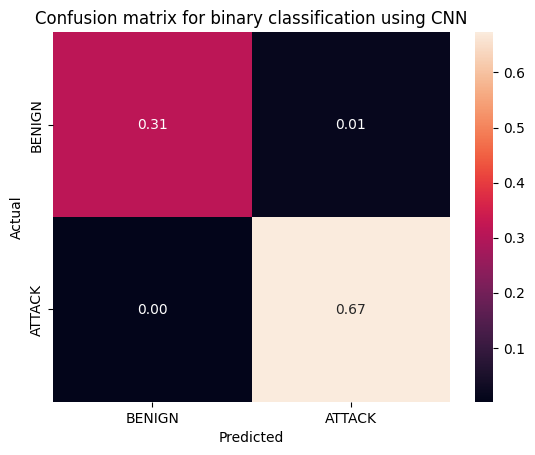

In [37]:
from sklearn.metrics import confusion_matrix
plt.title('Confusion matrix for binary classification using CNN')
ax=sns.heatmap(confusion_matrix(y_test_bin,pred_cnn_bin)/len(y_test_bin),annot=True,fmt='.2f',xticklabels=bin_classes,yticklabels=bin_classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn_bin=KNeighborsClassifier()
knn_bin.fit(X_train_bert,y_train_bin)
pred_knn_bin=knn_bin.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_test_bin,pred_knn_bin))
print('Classification Report:\n',classification_report(y_test_bin,pred_knn_bin,target_names=bin_classes))
joblib.dump(knn_bin,'knn_bin.pkl')

Accuracy: 0.9743962740054442
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.99      0.93      0.96     52000
      ATTACK       0.97      1.00      0.98    108172

    accuracy                           0.97    160172
   macro avg       0.98      0.96      0.97    160172
weighted avg       0.98      0.97      0.97    160172



['knn_bin.pkl']

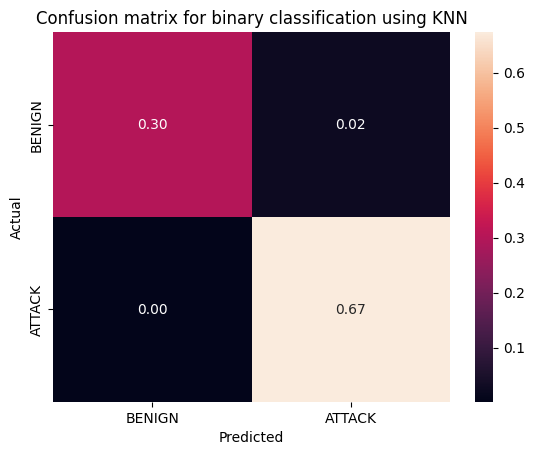

In [45]:
from sklearn.metrics import confusion_matrix
plt.title('Confusion matrix for binary classification using KNN')
ax=sns.heatmap(confusion_matrix(y_test_bin,pred_knn_bin)/len(y_test_bin),annot=True,fmt='.2f',xticklabels=bin_classes,yticklabels=bin_classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [38]:
from sklearn.linear_model import LogisticRegression
lr_bin=LogisticRegression()
lr_bin.fit(X_train_bert,y_train_bin)
pred_lr_bin=lr_bin.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_test_bin,pred_lr_bin))
print('Classification Report:\n',classification_report(y_test_bin,pred_lr_bin,target_names=bin_classes))
joblib.dump(lr_bin,'logistic_bin.pkl')

Accuracy: 0.9609544739405139
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.97      0.90      0.94     52000
      ATTACK       0.96      0.99      0.97    108172

    accuracy                           0.96    160172
   macro avg       0.96      0.95      0.95    160172
weighted avg       0.96      0.96      0.96    160172



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logistic_bin.pkl']

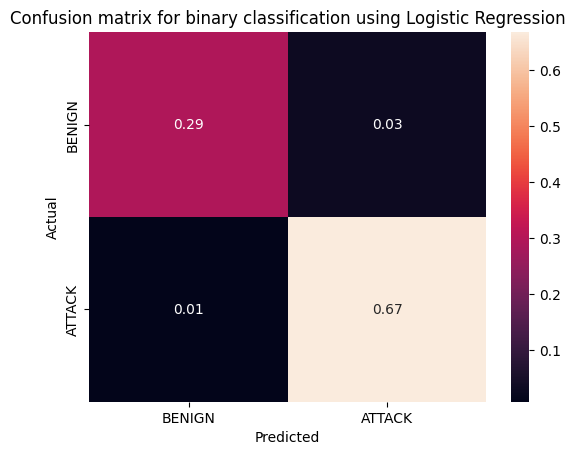

In [39]:
from sklearn.metrics import confusion_matrix
plt.title('Confusion matrix for binary classification using Logistic Regression')
ax=sns.heatmap(confusion_matrix(y_test_bin,pred_lr_bin)/len(y_test_bin),annot=True,fmt='.2f',xticklabels=bin_classes,yticklabels=bin_classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [40]:
from sklearn.tree import DecisionTreeClassifier
dt_bin=DecisionTreeClassifier(max_depth=10)
dt_bin.fit(X_train_bert,y_train_bin)
pred_dt_bin=dt_bin.predict(X_test_bert)
print('Accuracy:',accuracy_score(y_test_bin,pred_dt_bin))
print('Classification Report:\n',classification_report(y_test_bin,pred_dt_bin,target_names=bin_classes))
joblib.dump(dt_bin,'dt_bin.pkl')

Accuracy: 0.8819643882825962
Classification Report:
               precision    recall  f1-score   support

      BENIGN       0.90      0.71      0.80     52000
      ATTACK       0.87      0.96      0.92    108172

    accuracy                           0.88    160172
   macro avg       0.89      0.84      0.86    160172
weighted avg       0.88      0.88      0.88    160172



['dt_bin.pkl']

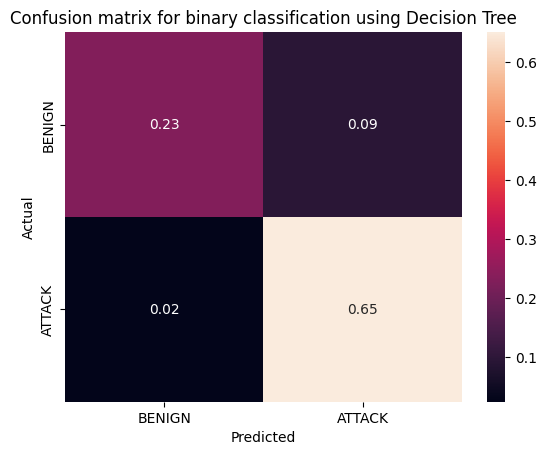

In [41]:
from sklearn.metrics import confusion_matrix
plt.title('Confusion matrix for binary classification using Decision Tree')
ax=sns.heatmap(confusion_matrix(y_test_bin,pred_dt_bin)/len(y_test_bin),annot=True,fmt='.2f',xticklabels=bin_classes,yticklabels=bin_classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [47]:
model_test=joblib.load(r'/kaggle/working/dt.pkl')
prediction=model_test.predict(X_test_bert)
print(accuracy_score(y_testdf,prediction))

0.8038858227405539


In [22]:
mlp_bin=tf.keras.models.load_model(r'/kaggle/working/mlp_bin.h5')
pred_mlp=mlp_bin.predict(X_test_bert)
pred_mlp=(pred_mlp >=0.5).astype(int).flatten()

cnn_bin=tf.keras.models.load_model(r'/kaggle/working/cnn_bin.h5')
pred_cnn=cnn_bin.predict(X_test_bert)
pred_cnn=(pred_cnn >=0.5).astype(int).flatten()

lr_bin=joblib.load(r'/kaggle/working/logistic_bin.pkl')
pred_lr=lr_bin.predict(X_test_bert)

dt_bin=joblib.load(r'/kaggle/working/dt_bin.pkl')
pred_dt=dt_bin.predict(X_test_bert)

knn_bin=joblib.load(r'/kaggle/working/knn_bin.pkl')
pred_knn=knn_bin.predict(X_test_bert)

5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


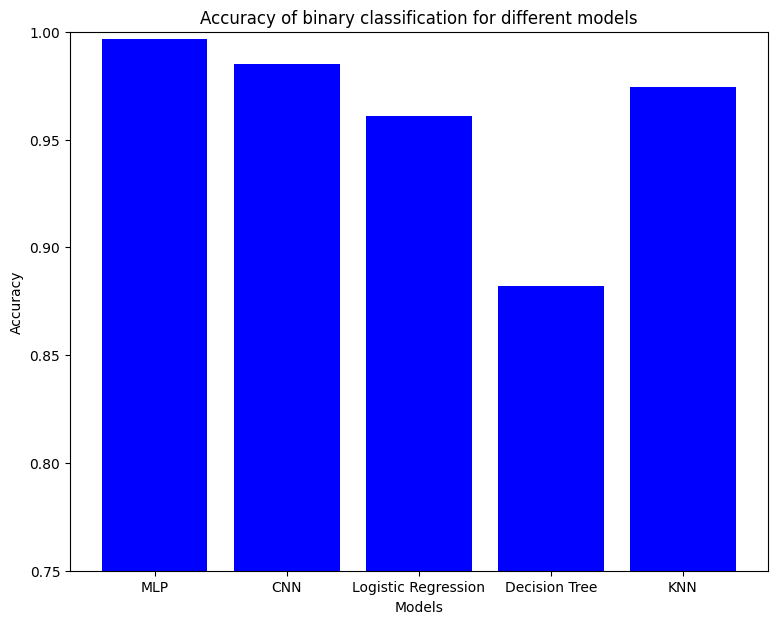

In [26]:
from sklearn.metrics import accuracy_score
models=['MLP','CNN','Logistic Regression','Decision Tree','KNN']
accuracies=[]
accuracies.append(accuracy_score(y_test_bin,pred_mlp))
accuracies.append(accuracy_score(y_test_bin,pred_cnn))
accuracies.append(accuracy_score(y_test_bin,pred_lr))
accuracies.append(accuracy_score(y_test_bin,pred_dt))
accuracies.append(accuracy_score(y_test_bin,pred_knn))

plt.figure(figsize=(9,7))
plt.title('Accuracy of binary classification for different models')
plt.bar(models,accuracies,color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.75,1.0)
plt.yticks(np.arange(0.75,1.01,0.05))
plt.savefig('accuracy_bin.jpg',dpi=300,bbox_inches='tight')
plt.show()

5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5006/5006 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


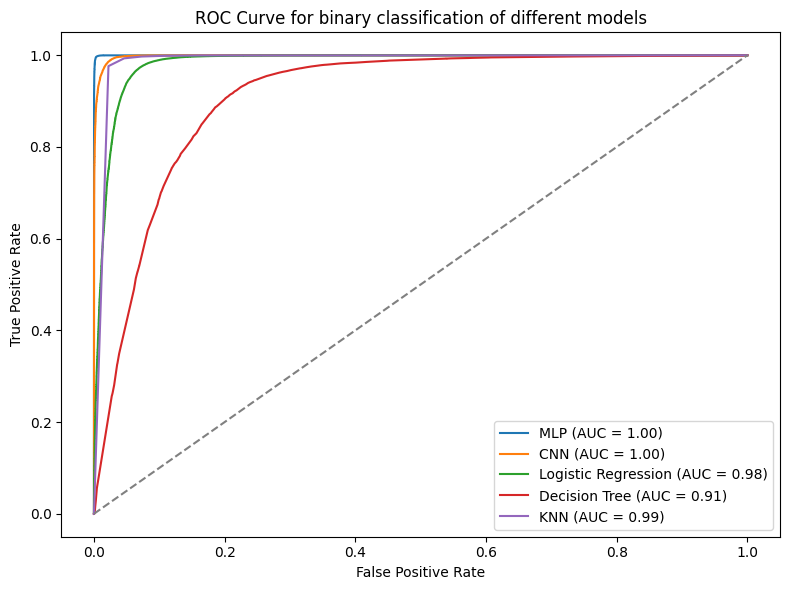

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

mlp_bin=tf.keras.models.load_model(r'/kaggle/working/mlp_bin.h5')
cnn_bin=tf.keras.models.load_model(r'/kaggle/working/cnn_bin.h5')
lr_bin=joblib.load(r'/kaggle/working/logistic_bin.pkl')
dt_bin=joblib.load(r'/kaggle/working/dt_bin.pkl')
knn_bin=joblib.load(r'/kaggle/working/knn_bin.pkl')

mlp_probs = mlp_bin.predict(X_test_bert).flatten()
cnn_probs = cnn_bin.predict(X_test_bert).flatten()

lr_probs = lr_bin.predict_proba(X_test_bert)[:, 1]
dt_probs = dt_bin.predict_proba(X_test_bert)[:, 1]
knn_probs = knn_bin.predict_proba(X_test_bert)[:, 1]


models = {
    'MLP': mlp_probs,
    'CNN': cnn_probs,
    'Logistic Regression': lr_probs,
    'Decision Tree': dt_probs,
    'KNN': knn_probs
}

plt.figure(figsize=(8, 6))

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin, probs)
    auc = roc_auc_score(y_test_bin, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for binary classification of different models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_bin.jpg',dpi=300,bbox_inches='tight')
plt.show()